## Setup

In [ ]:
library(tidyverse)
library(compositions)

freq_clr <- function(freq_table, sample_col, freq_col, celltype_col){
    freq_selected <- select(freq_table, all_of(c(freq_col, celltype_col, sample_col)))
    freq_grouped <- group_by(freq_selected, across(all_of(c(sample_col, celltype_col))))
    freq_clean <- summarise(freq_grouped, across(all_of(freq_col), function(x) mean(x, na.rm = TRUE)), .groups = 'drop')
    
    freq <- pivot_wider(freq_clean, 
                       id_cols = all_of(sample_col), 
                       names_from = all_of(celltype_col),
                       values_from = all_of(freq_col))
    
    freq_mx_cols <- select(freq, -all_of(sample_col))
    freq_mx <- as.matrix(freq_mx_cols)
    rownames(freq_mx) <- freq[[sample_col]]
    
    freq_clr_matrix <- compositions::clr(freq_mx)
    freq_clr_tibble <- as_tibble(freq_clr_matrix, rownames = sample_col)
    freq_clr <- pivot_longer(freq_clr_tibble,
                           cols = -all_of(sample_col), 
                           names_to = celltype_col, 
                           values_to = paste0(freq_col, '_clr'))
    
    freq_table_grouped <- group_by(freq_table, across(all_of(c(sample_col, celltype_col))))
    freq_table_clean <- summarise(freq_table_grouped,
                                 across(where(is.numeric), function(x) mean(x, na.rm = TRUE)),
                                 across(where(is.character), first),
                                 .groups = 'drop')
    
    freq_meta_clr <- full_join(freq_table_clean, freq_clr, by = c(sample_col, celltype_col))
    
    return(freq_meta_clr)
}

In [1]:
home <- "/home/workspace/"
path <- "pbmc_flow/data/NDMM PT1 data - Statistics (1).csv"
util <- "pbmc_flow/utils.R"

source(file.path(home, util))

df <- read.csv(file.path(home, path))
df <- mutate(df, Sample_ID = paste(Subject, Flu.Visit, sep = "_"))

celltypes <- c(
    "Naive Treg",
    "Memory Treg",
    "TEMRA CD4",
    "Naive CD4",
    "EM CD4",
    "TFH cells",
    "CD4 rm",
    "TEMRA CD8",
    "Naive CD8",
    "EM CD8",
    "CM CD8",
    "CD8 rm"
)

df <- filter(df, population %in% celltypes, percentOf == "Viable Cells")
df <- group_by(df, Subject, Flu.Visit, percentOf)
df <- mutate(df, total_percents = sum(percent, na.rm = TRUE), frequency = percent / total_percents)
df <- ungroup(df)

result <- freq_clr(
    freq_table = df,
    sample_col = "Sample_ID",
    freq_col = "frequency", 
    celltype_col = "population"
)

write.csv(result, "/home/workspace/pbmc_flow/data/tcell_composition_clr_results.csv", row.names = FALSE)

In [ ]:
names(result)
unique(result$Response)
# unique(result$Flu.Visit)
# unique(result$Subject)

$`Flu Year 1 Stand-Alone`

$`Flu Year 1 Day 0`


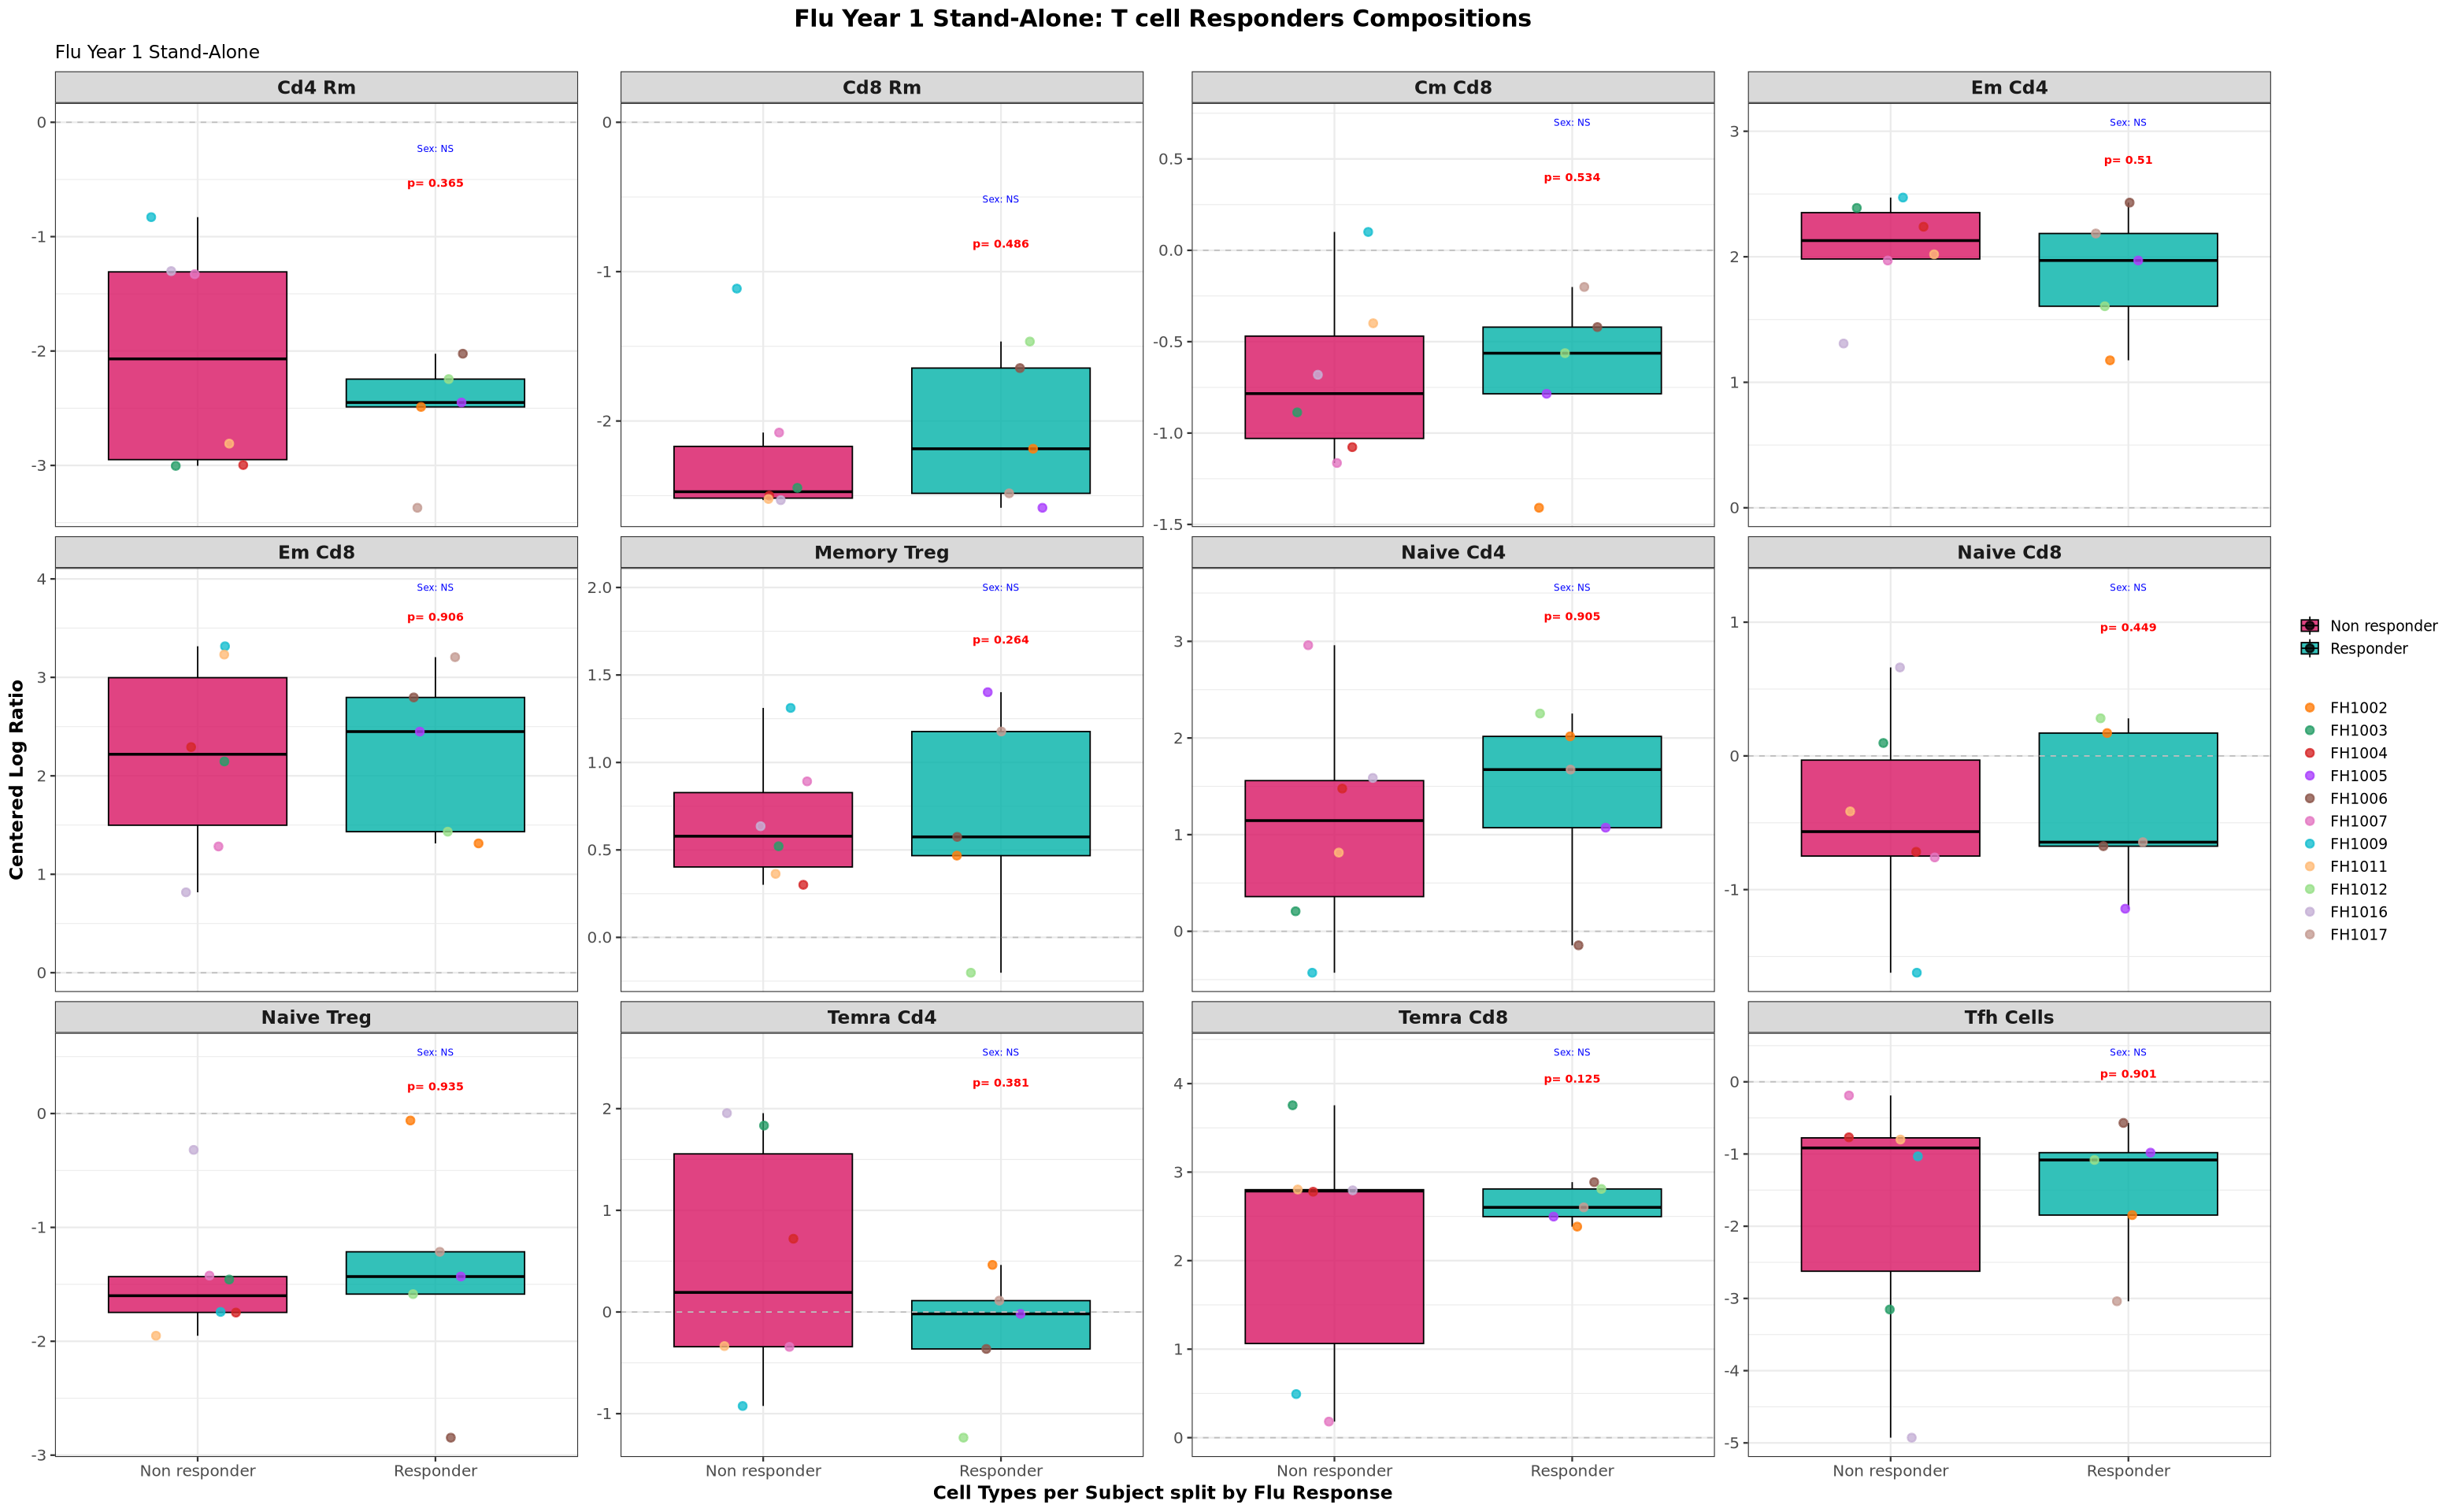


$`Flu Year 1 Day 7`


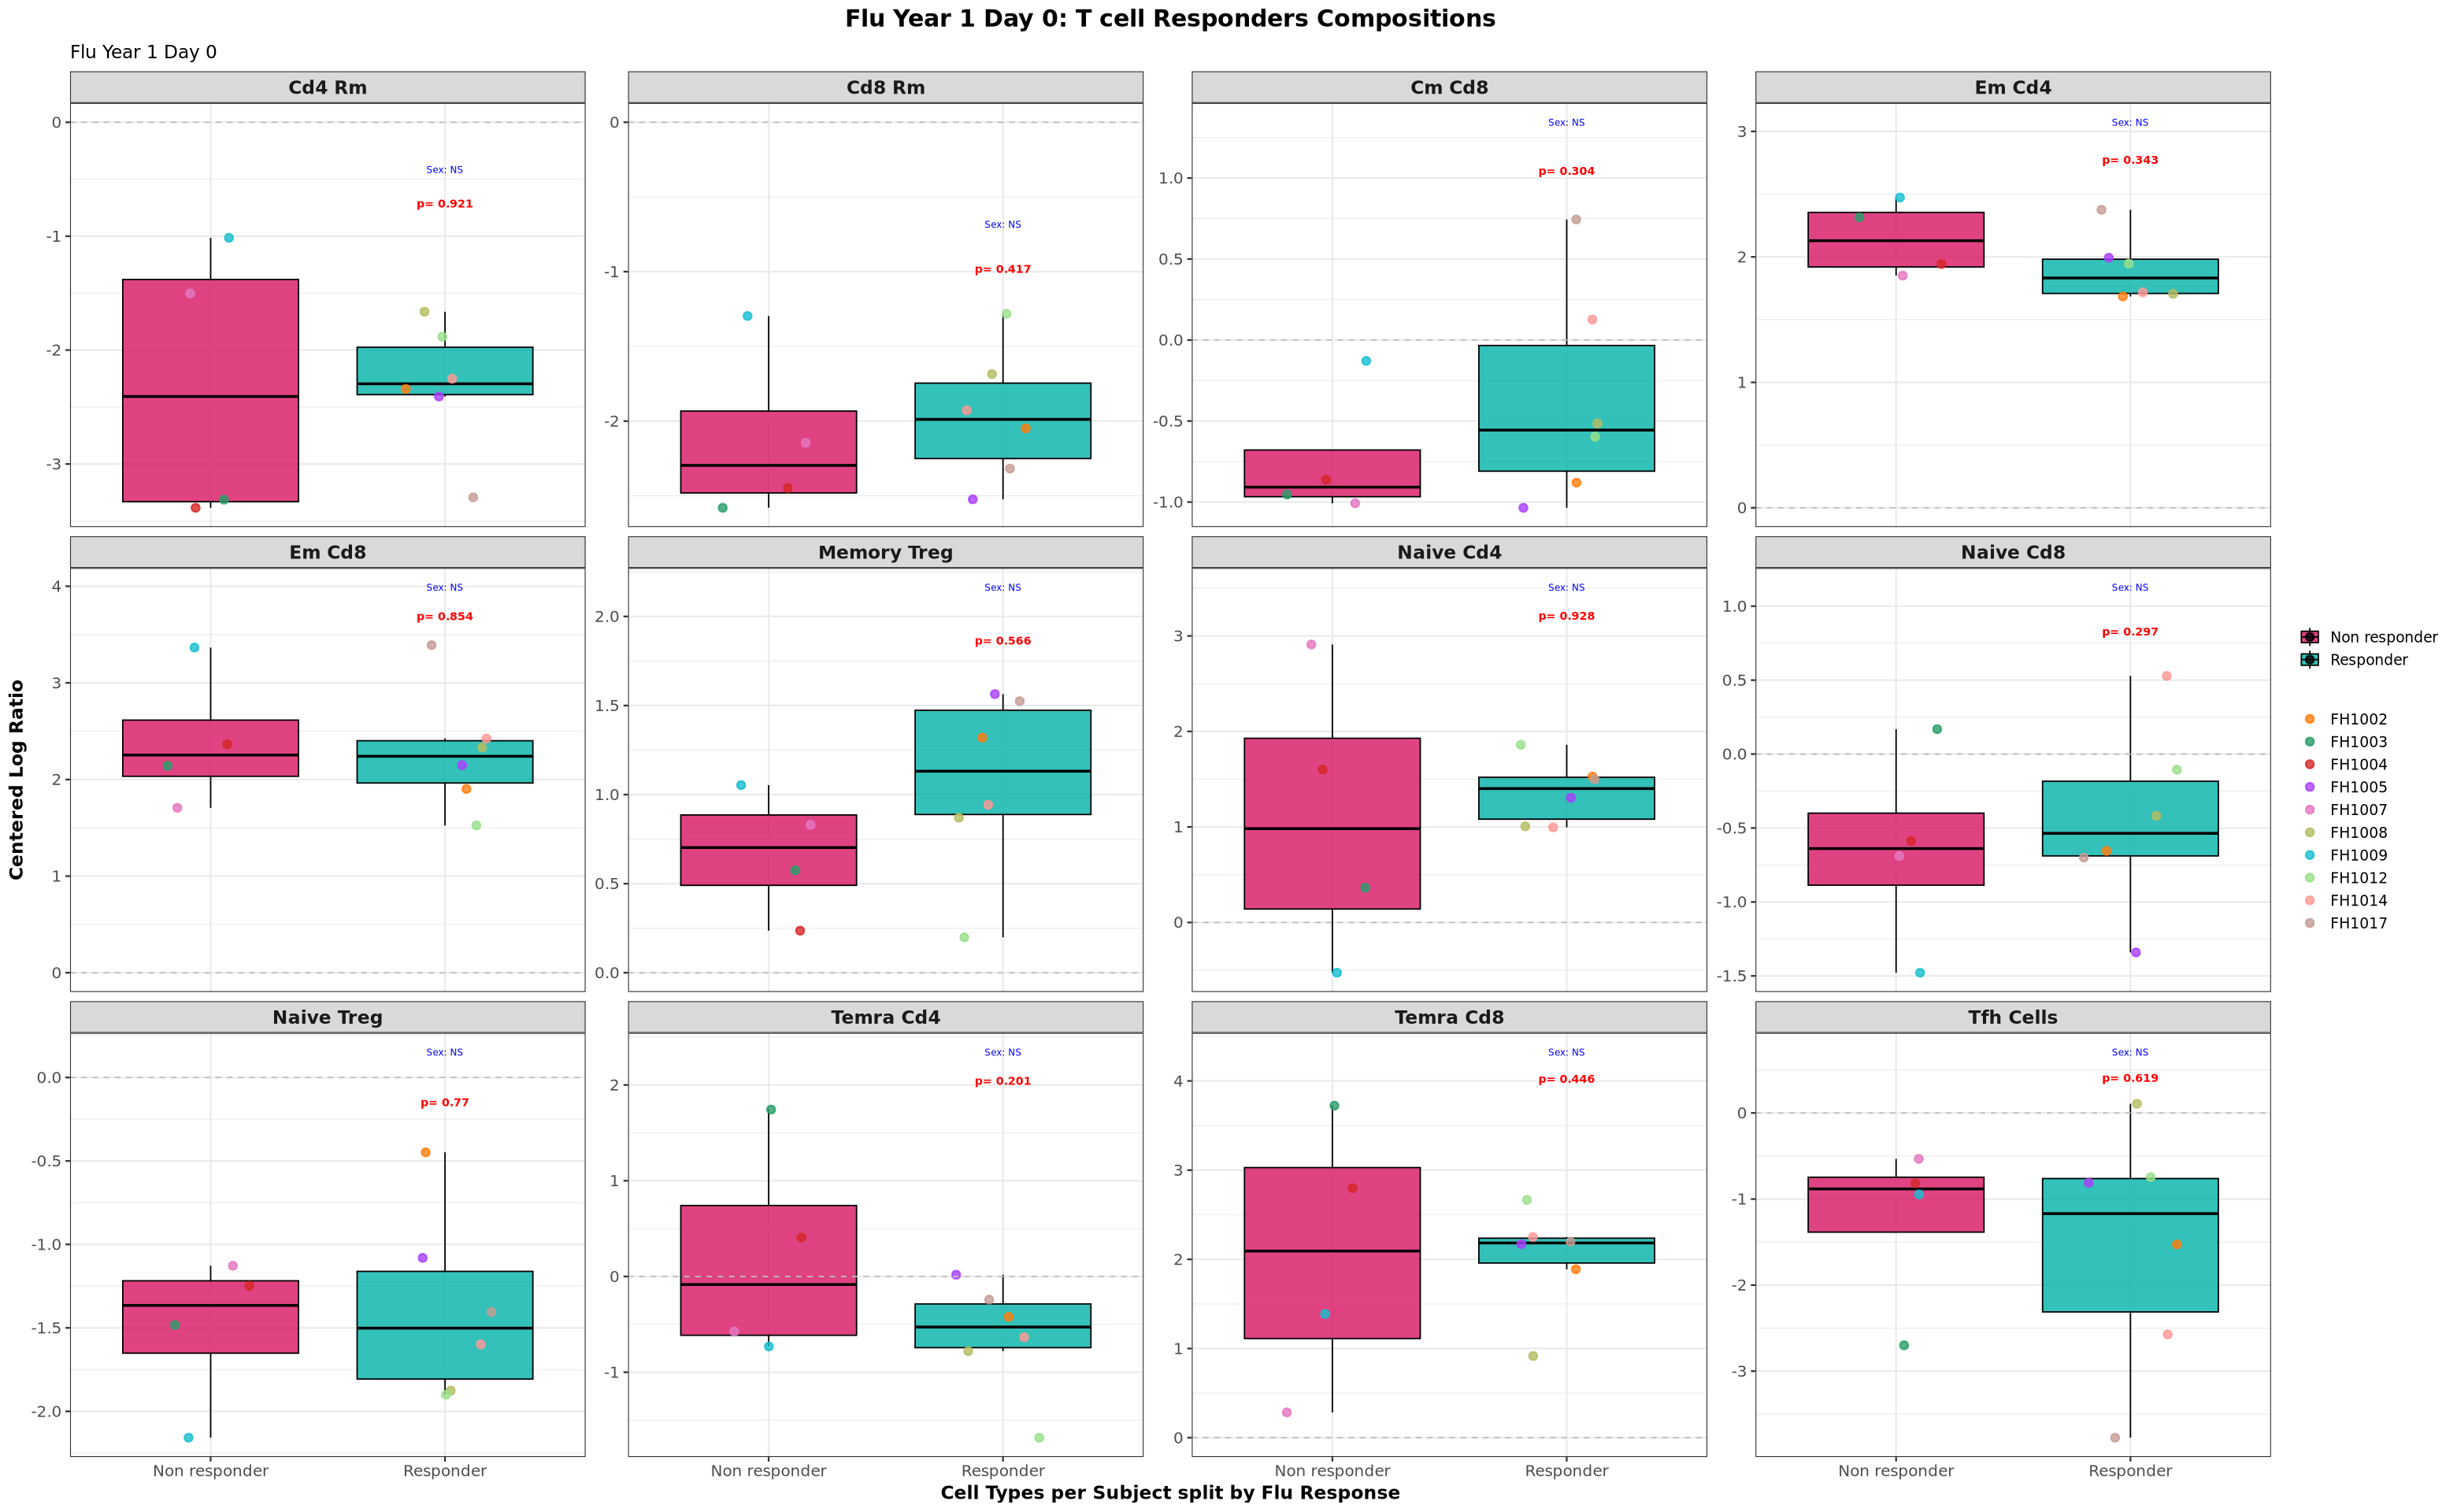


$`Flu Year 1 Day 90`


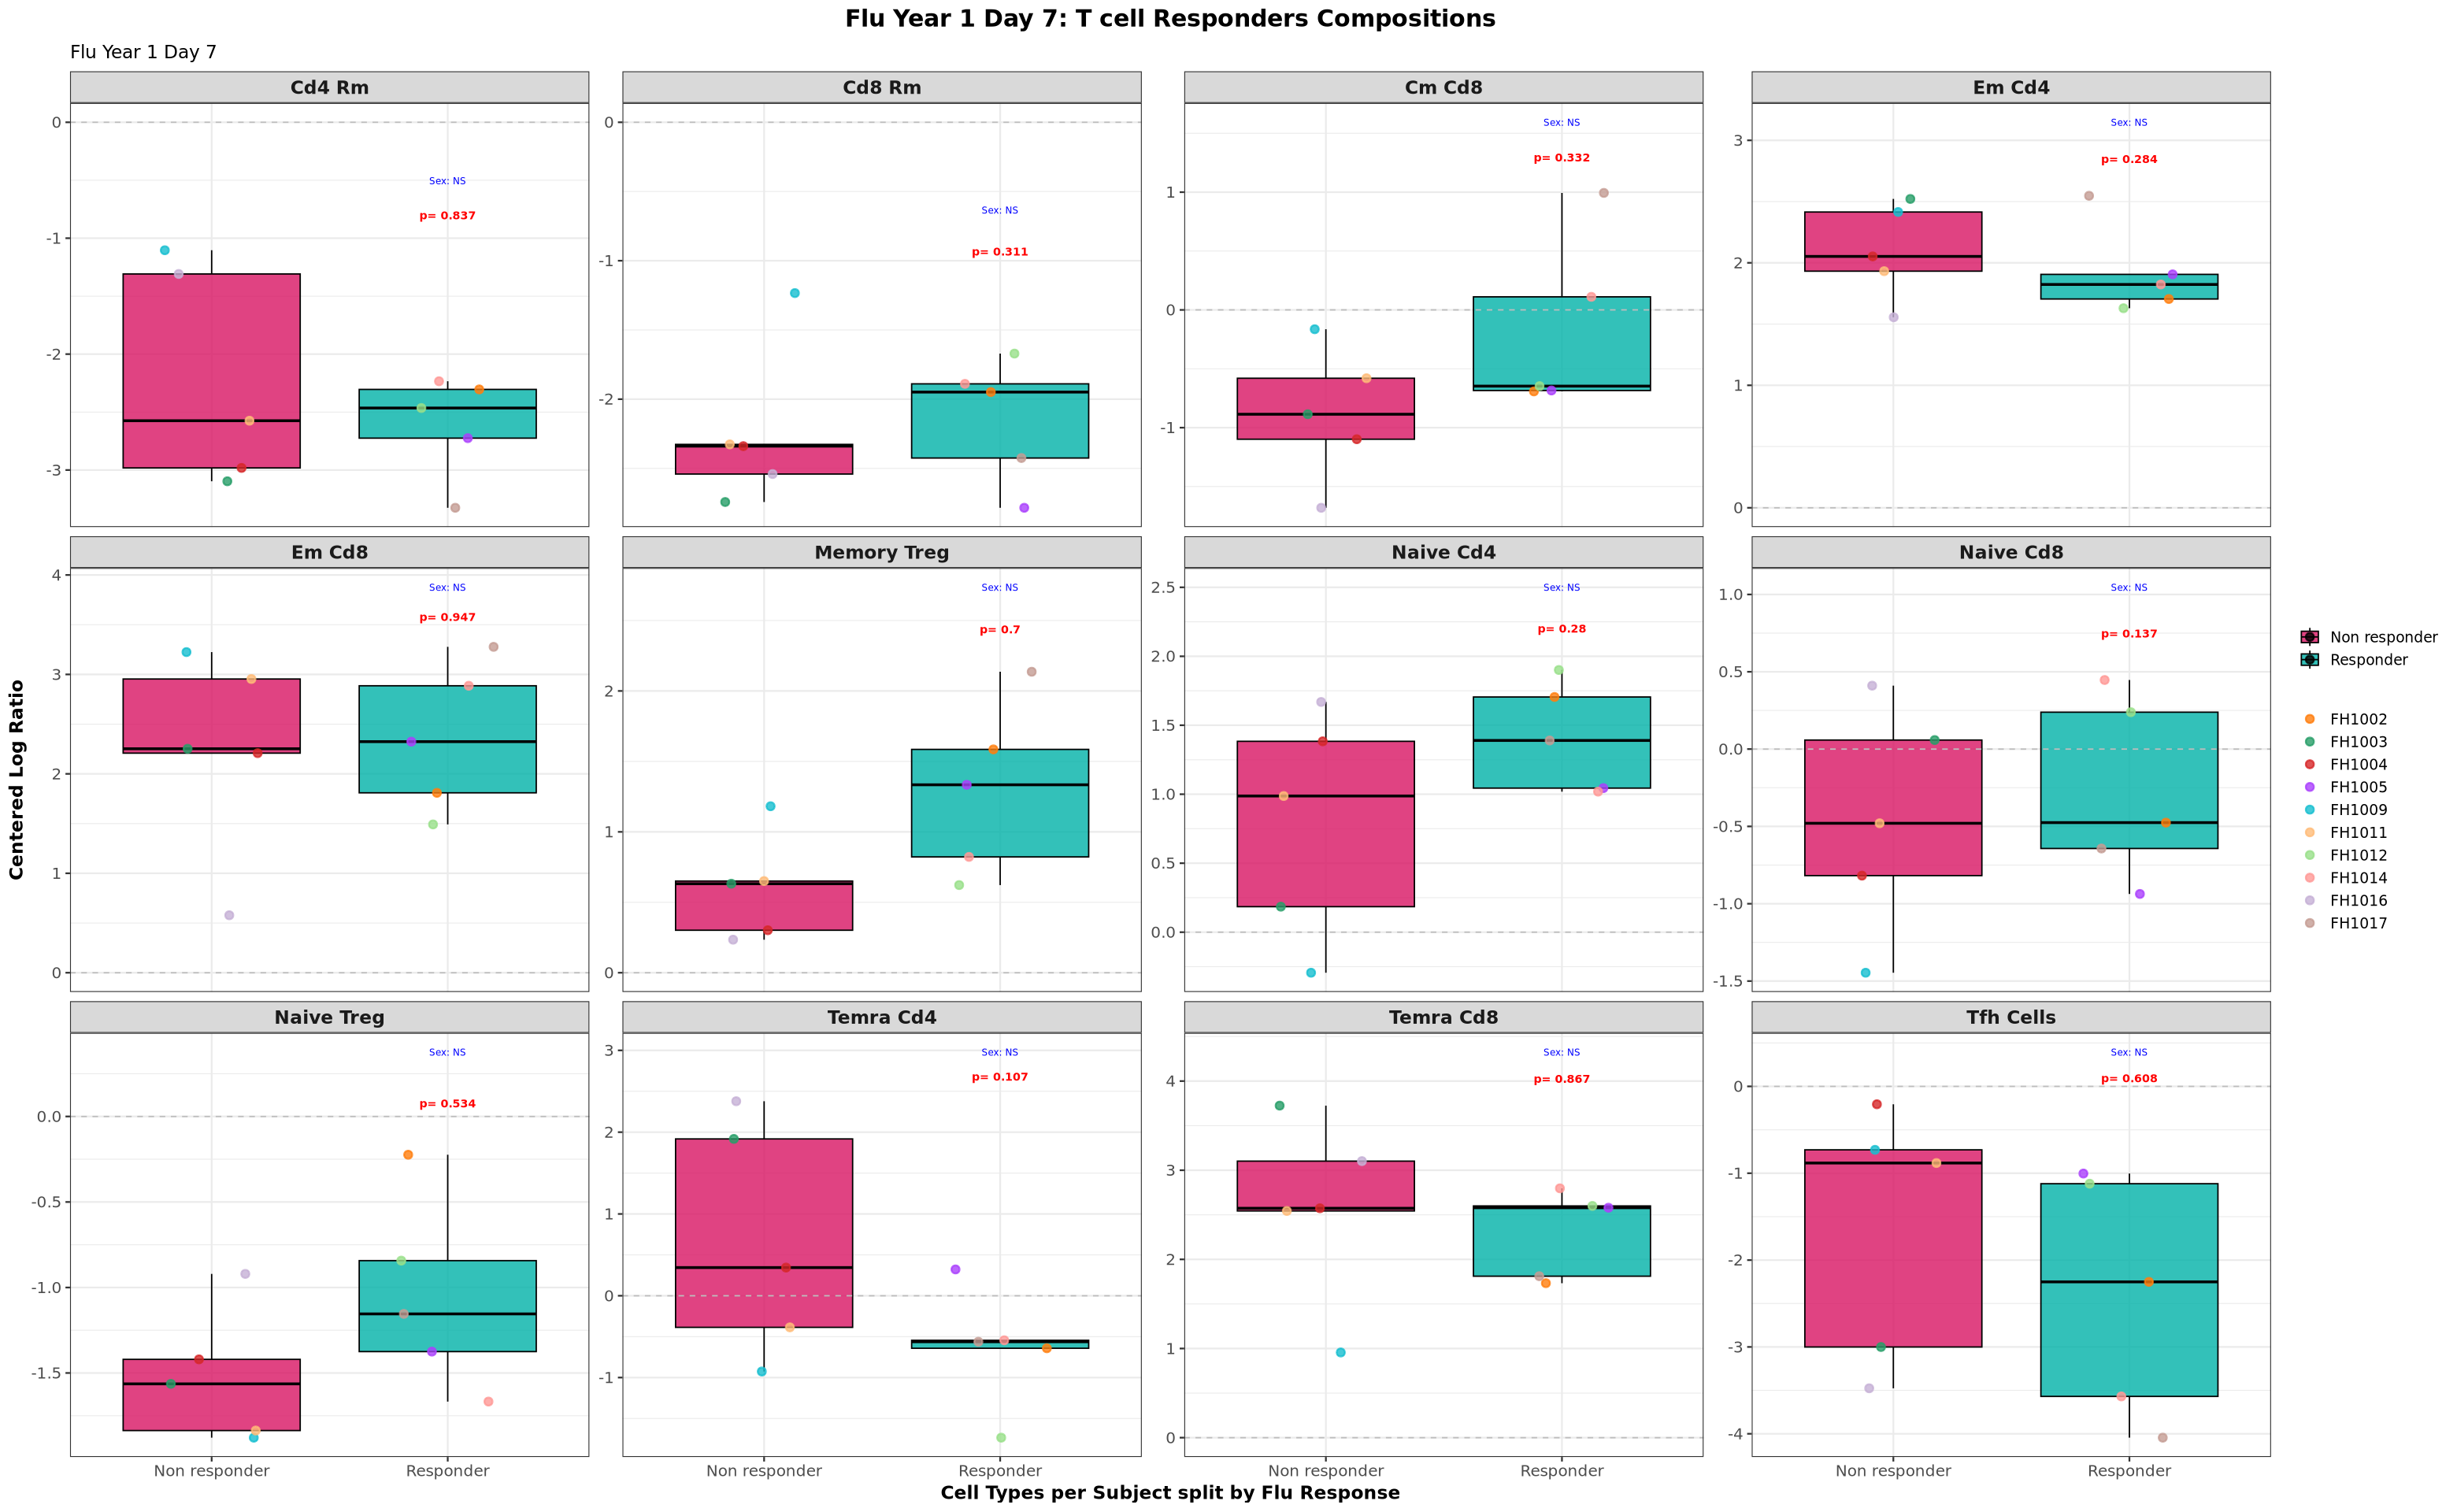


$`Flu Year 2 Stand-Alone`


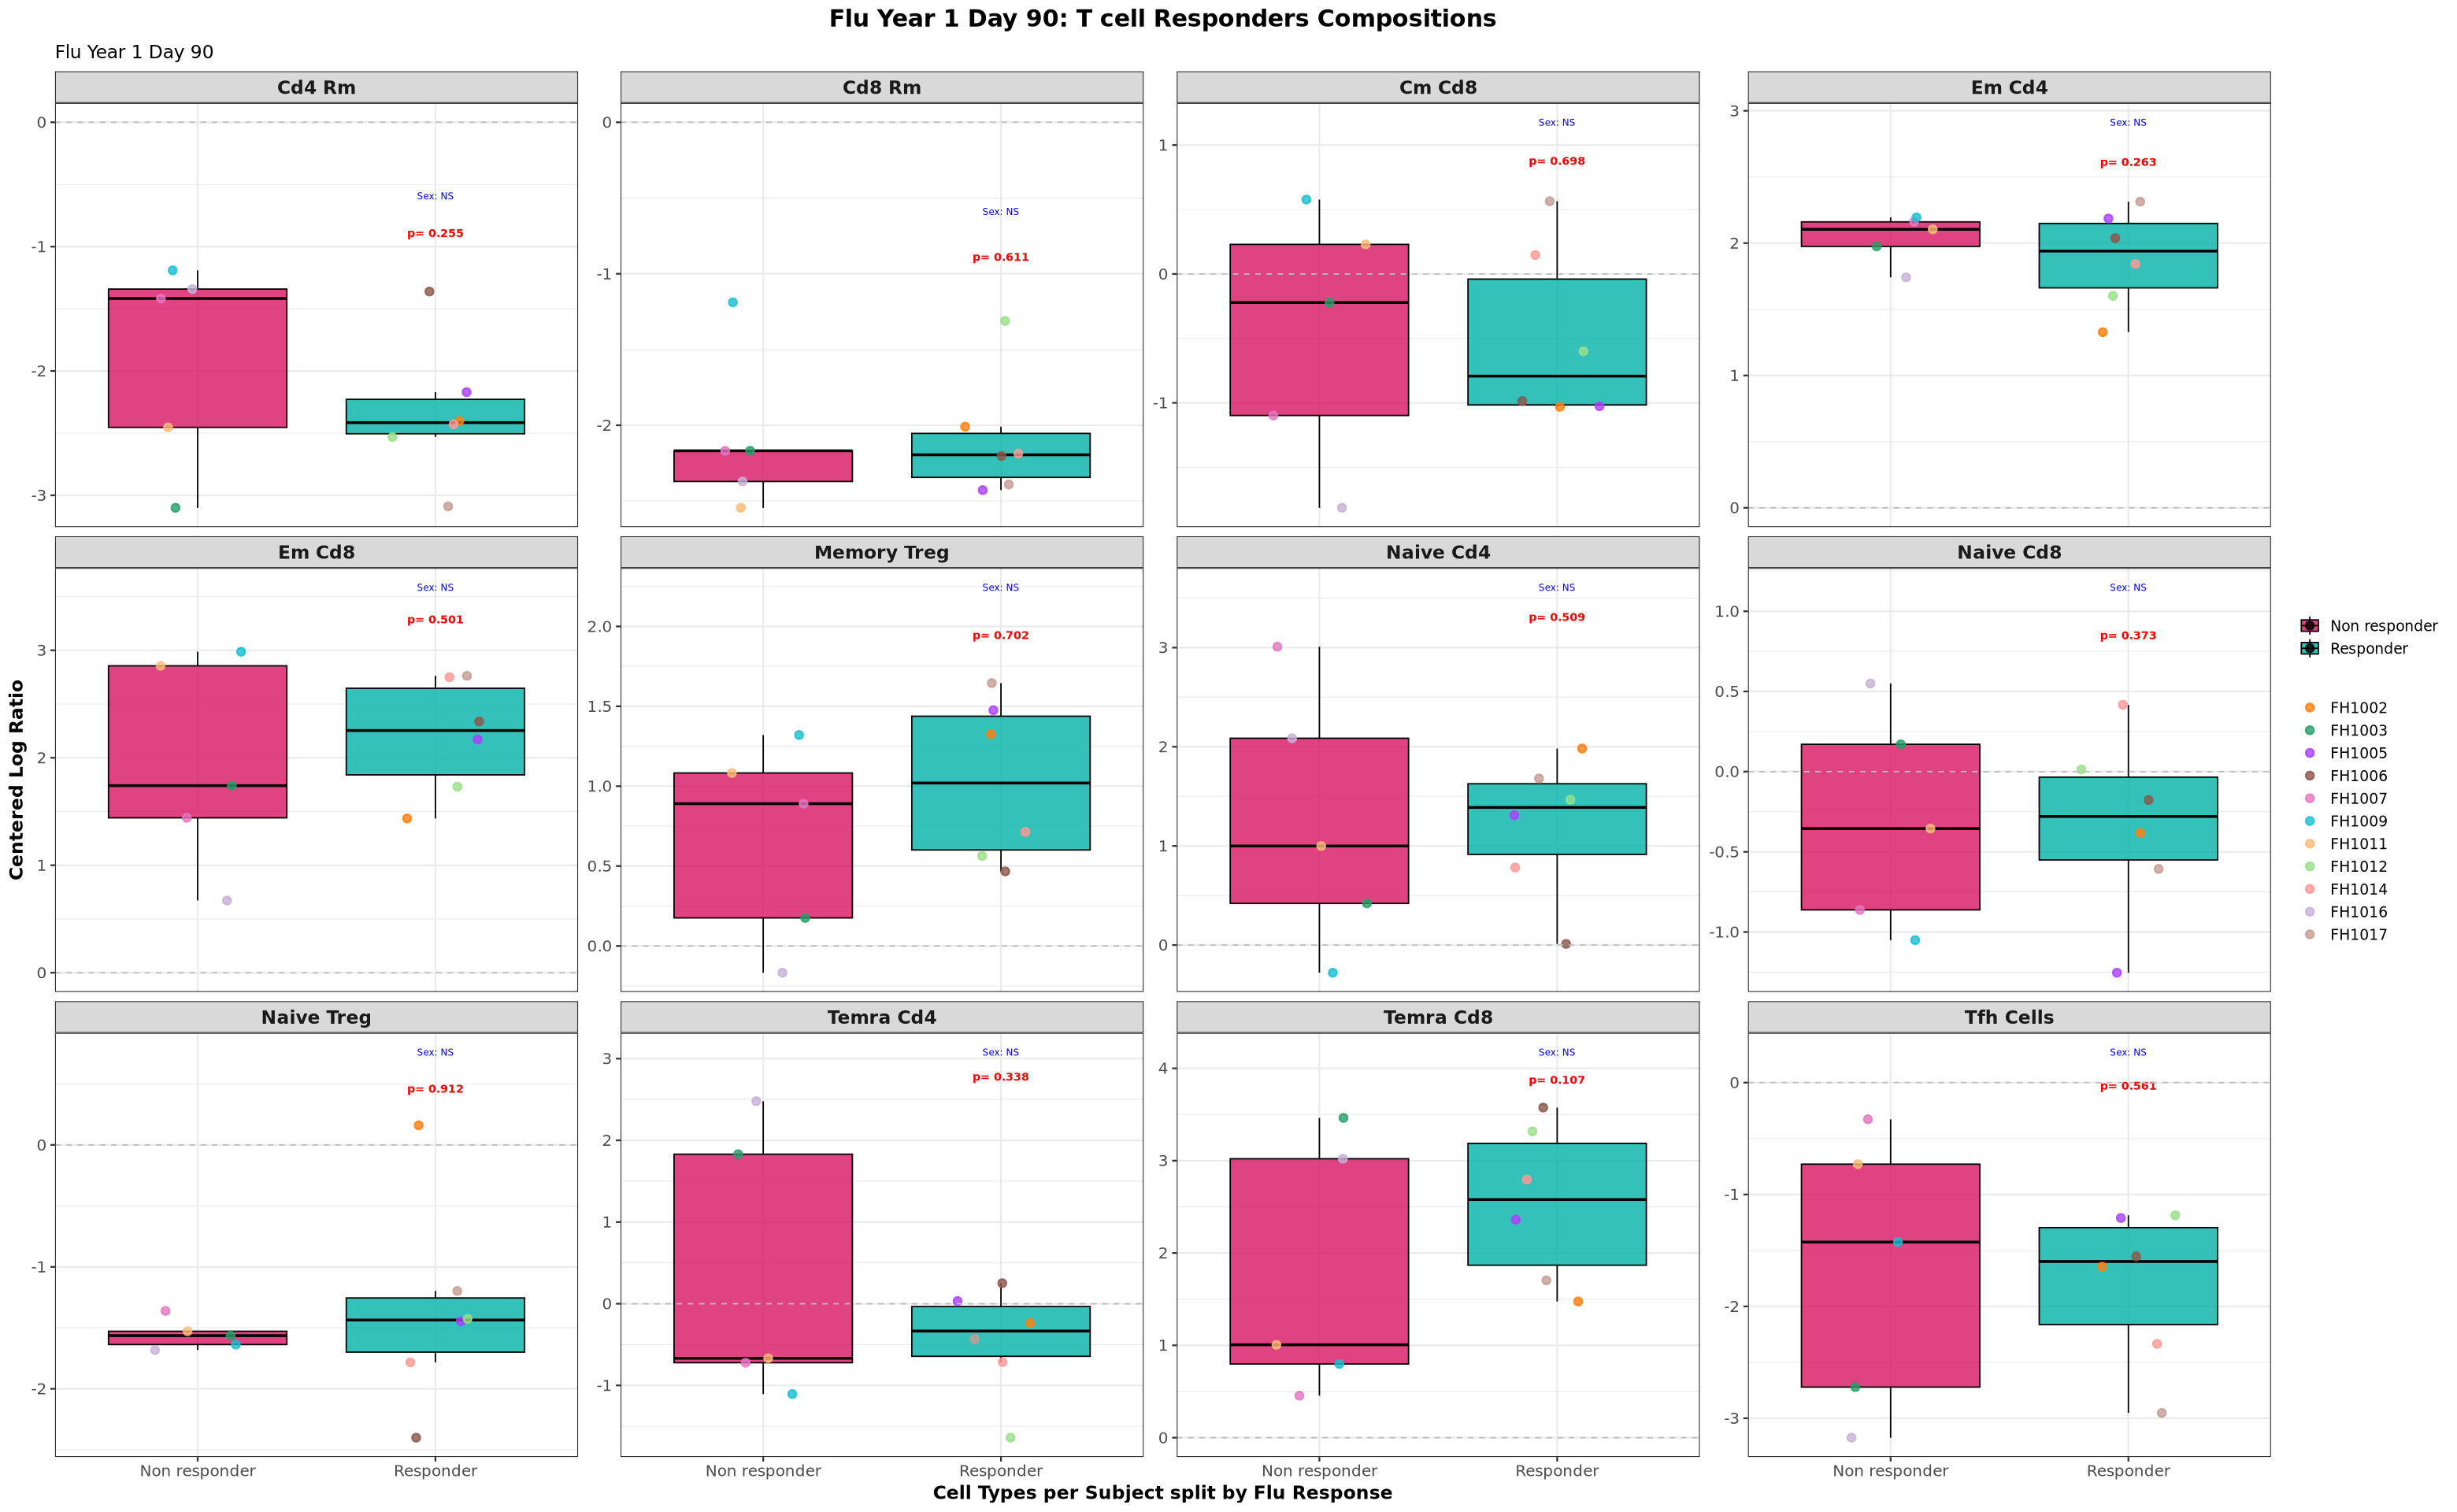


$`Flu Year 2 Day 0`


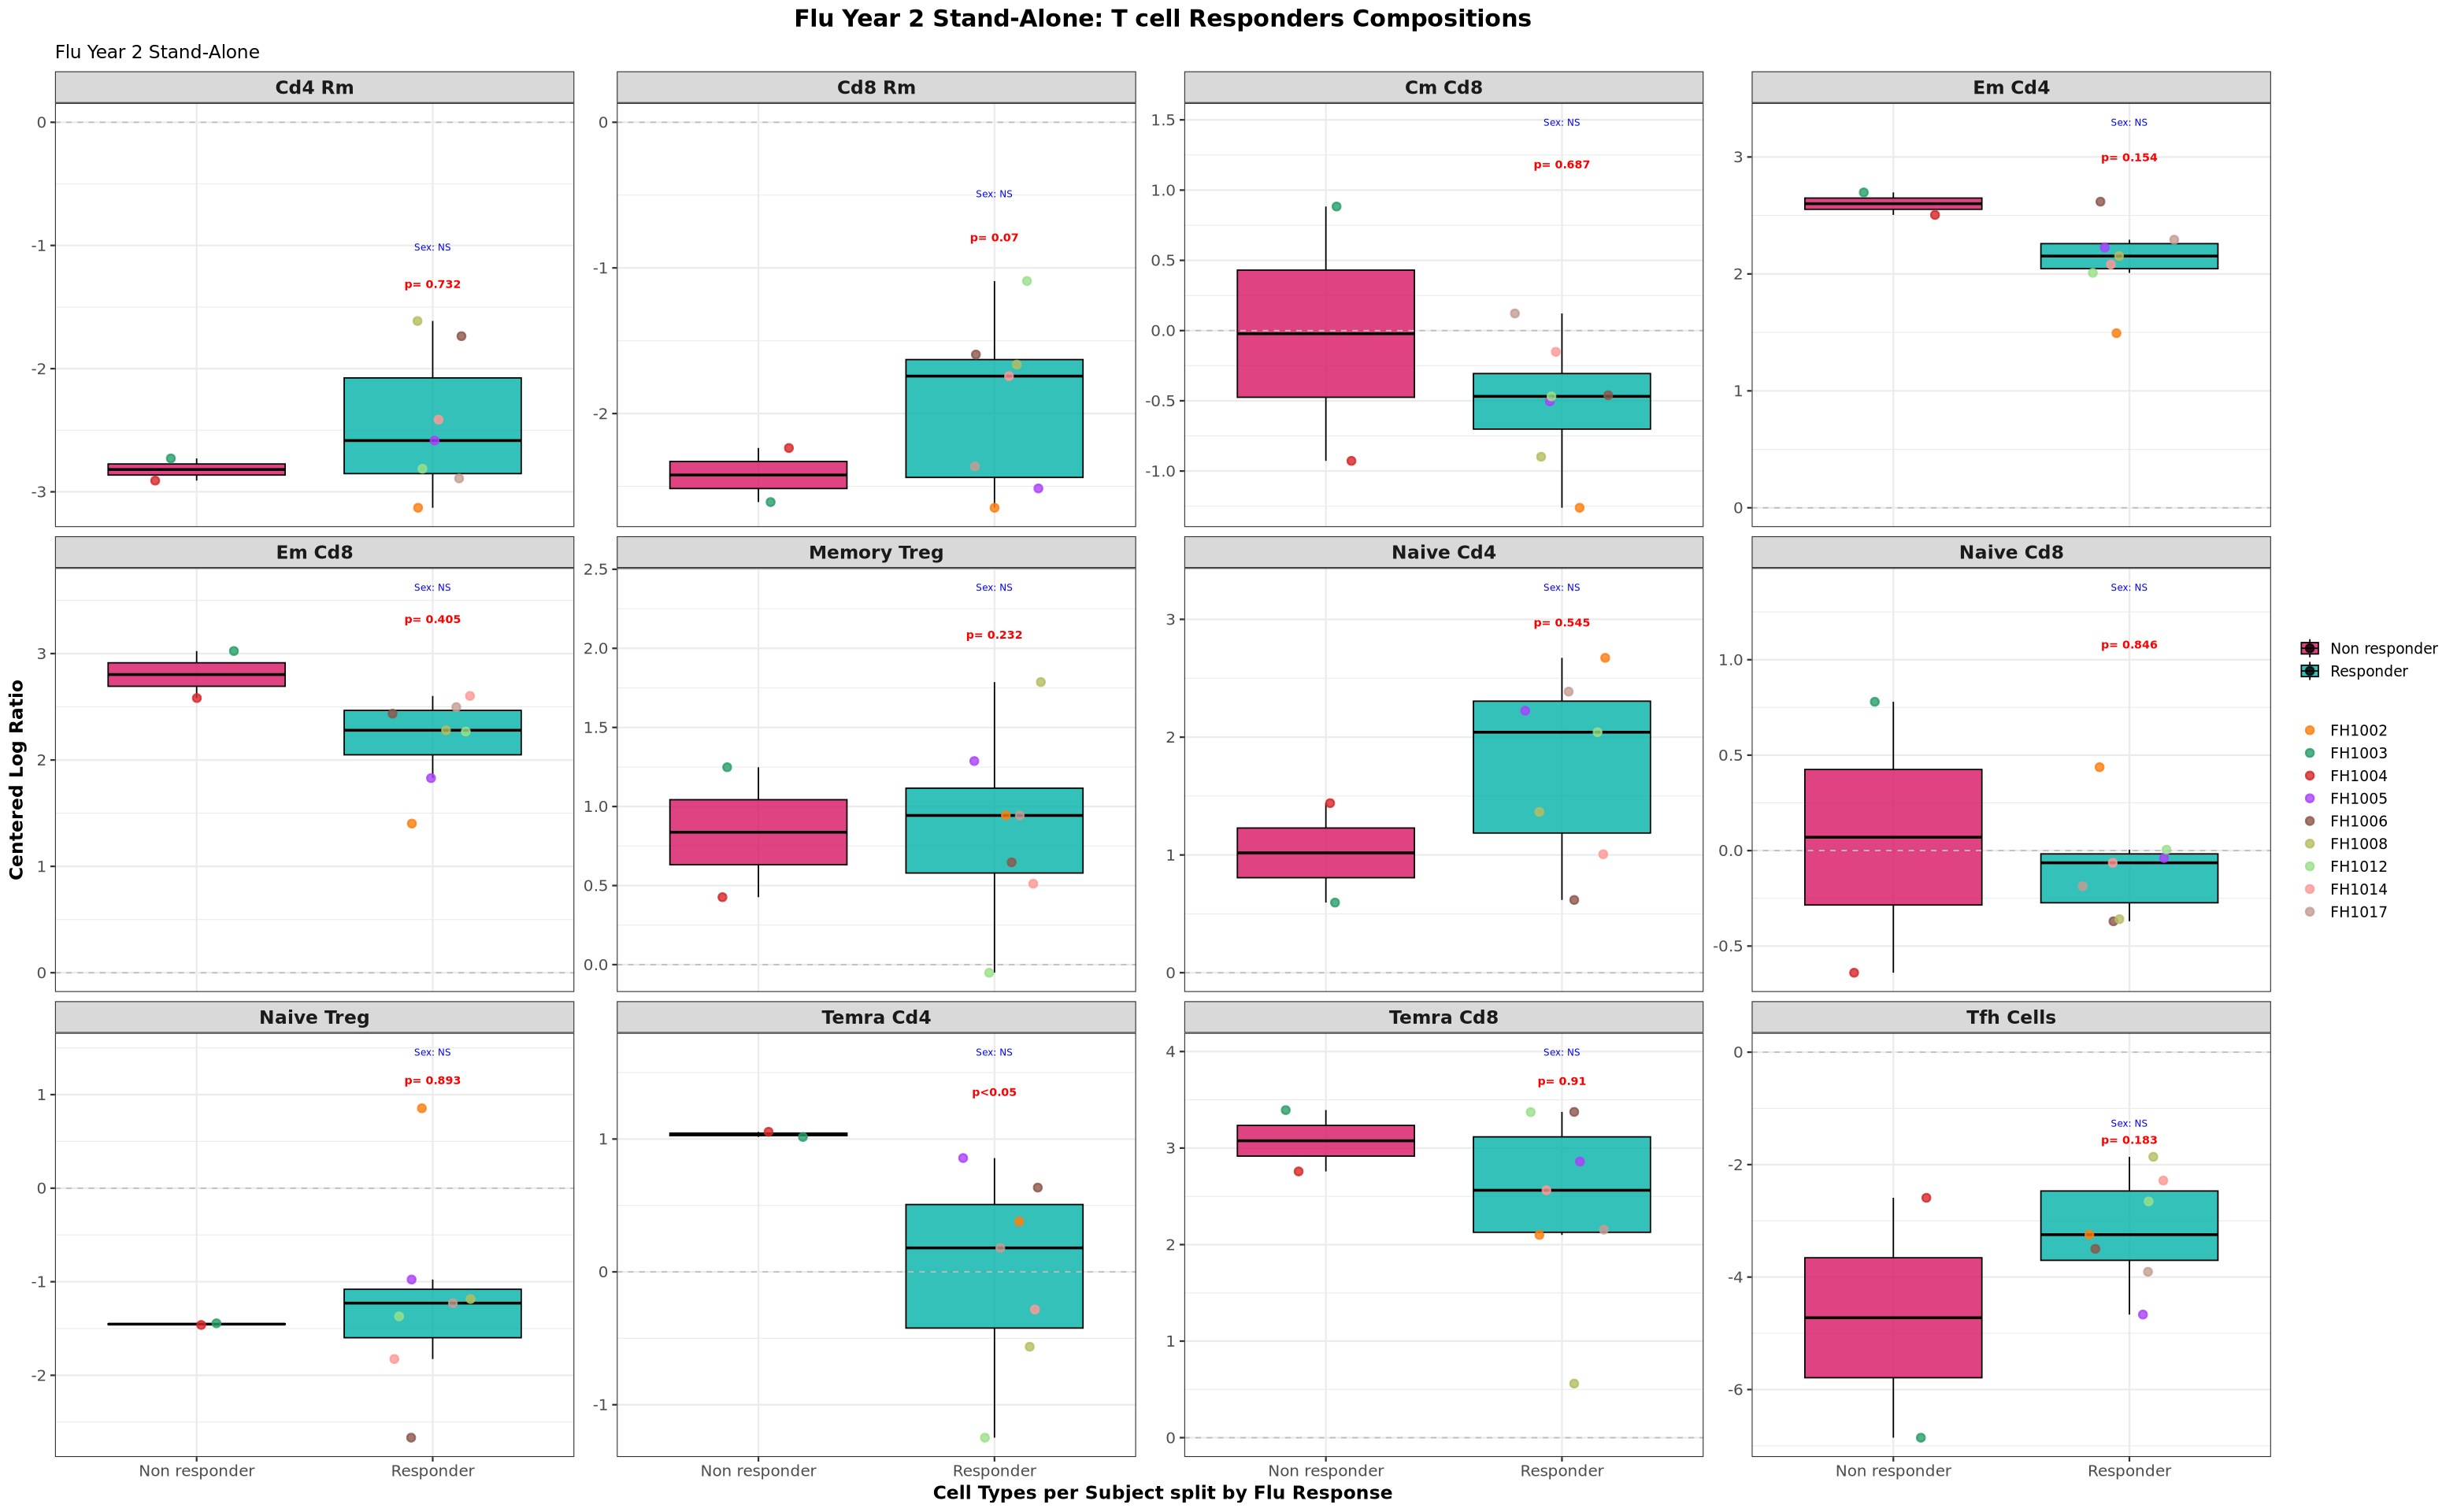


$`Flu Year 2 Day 7`


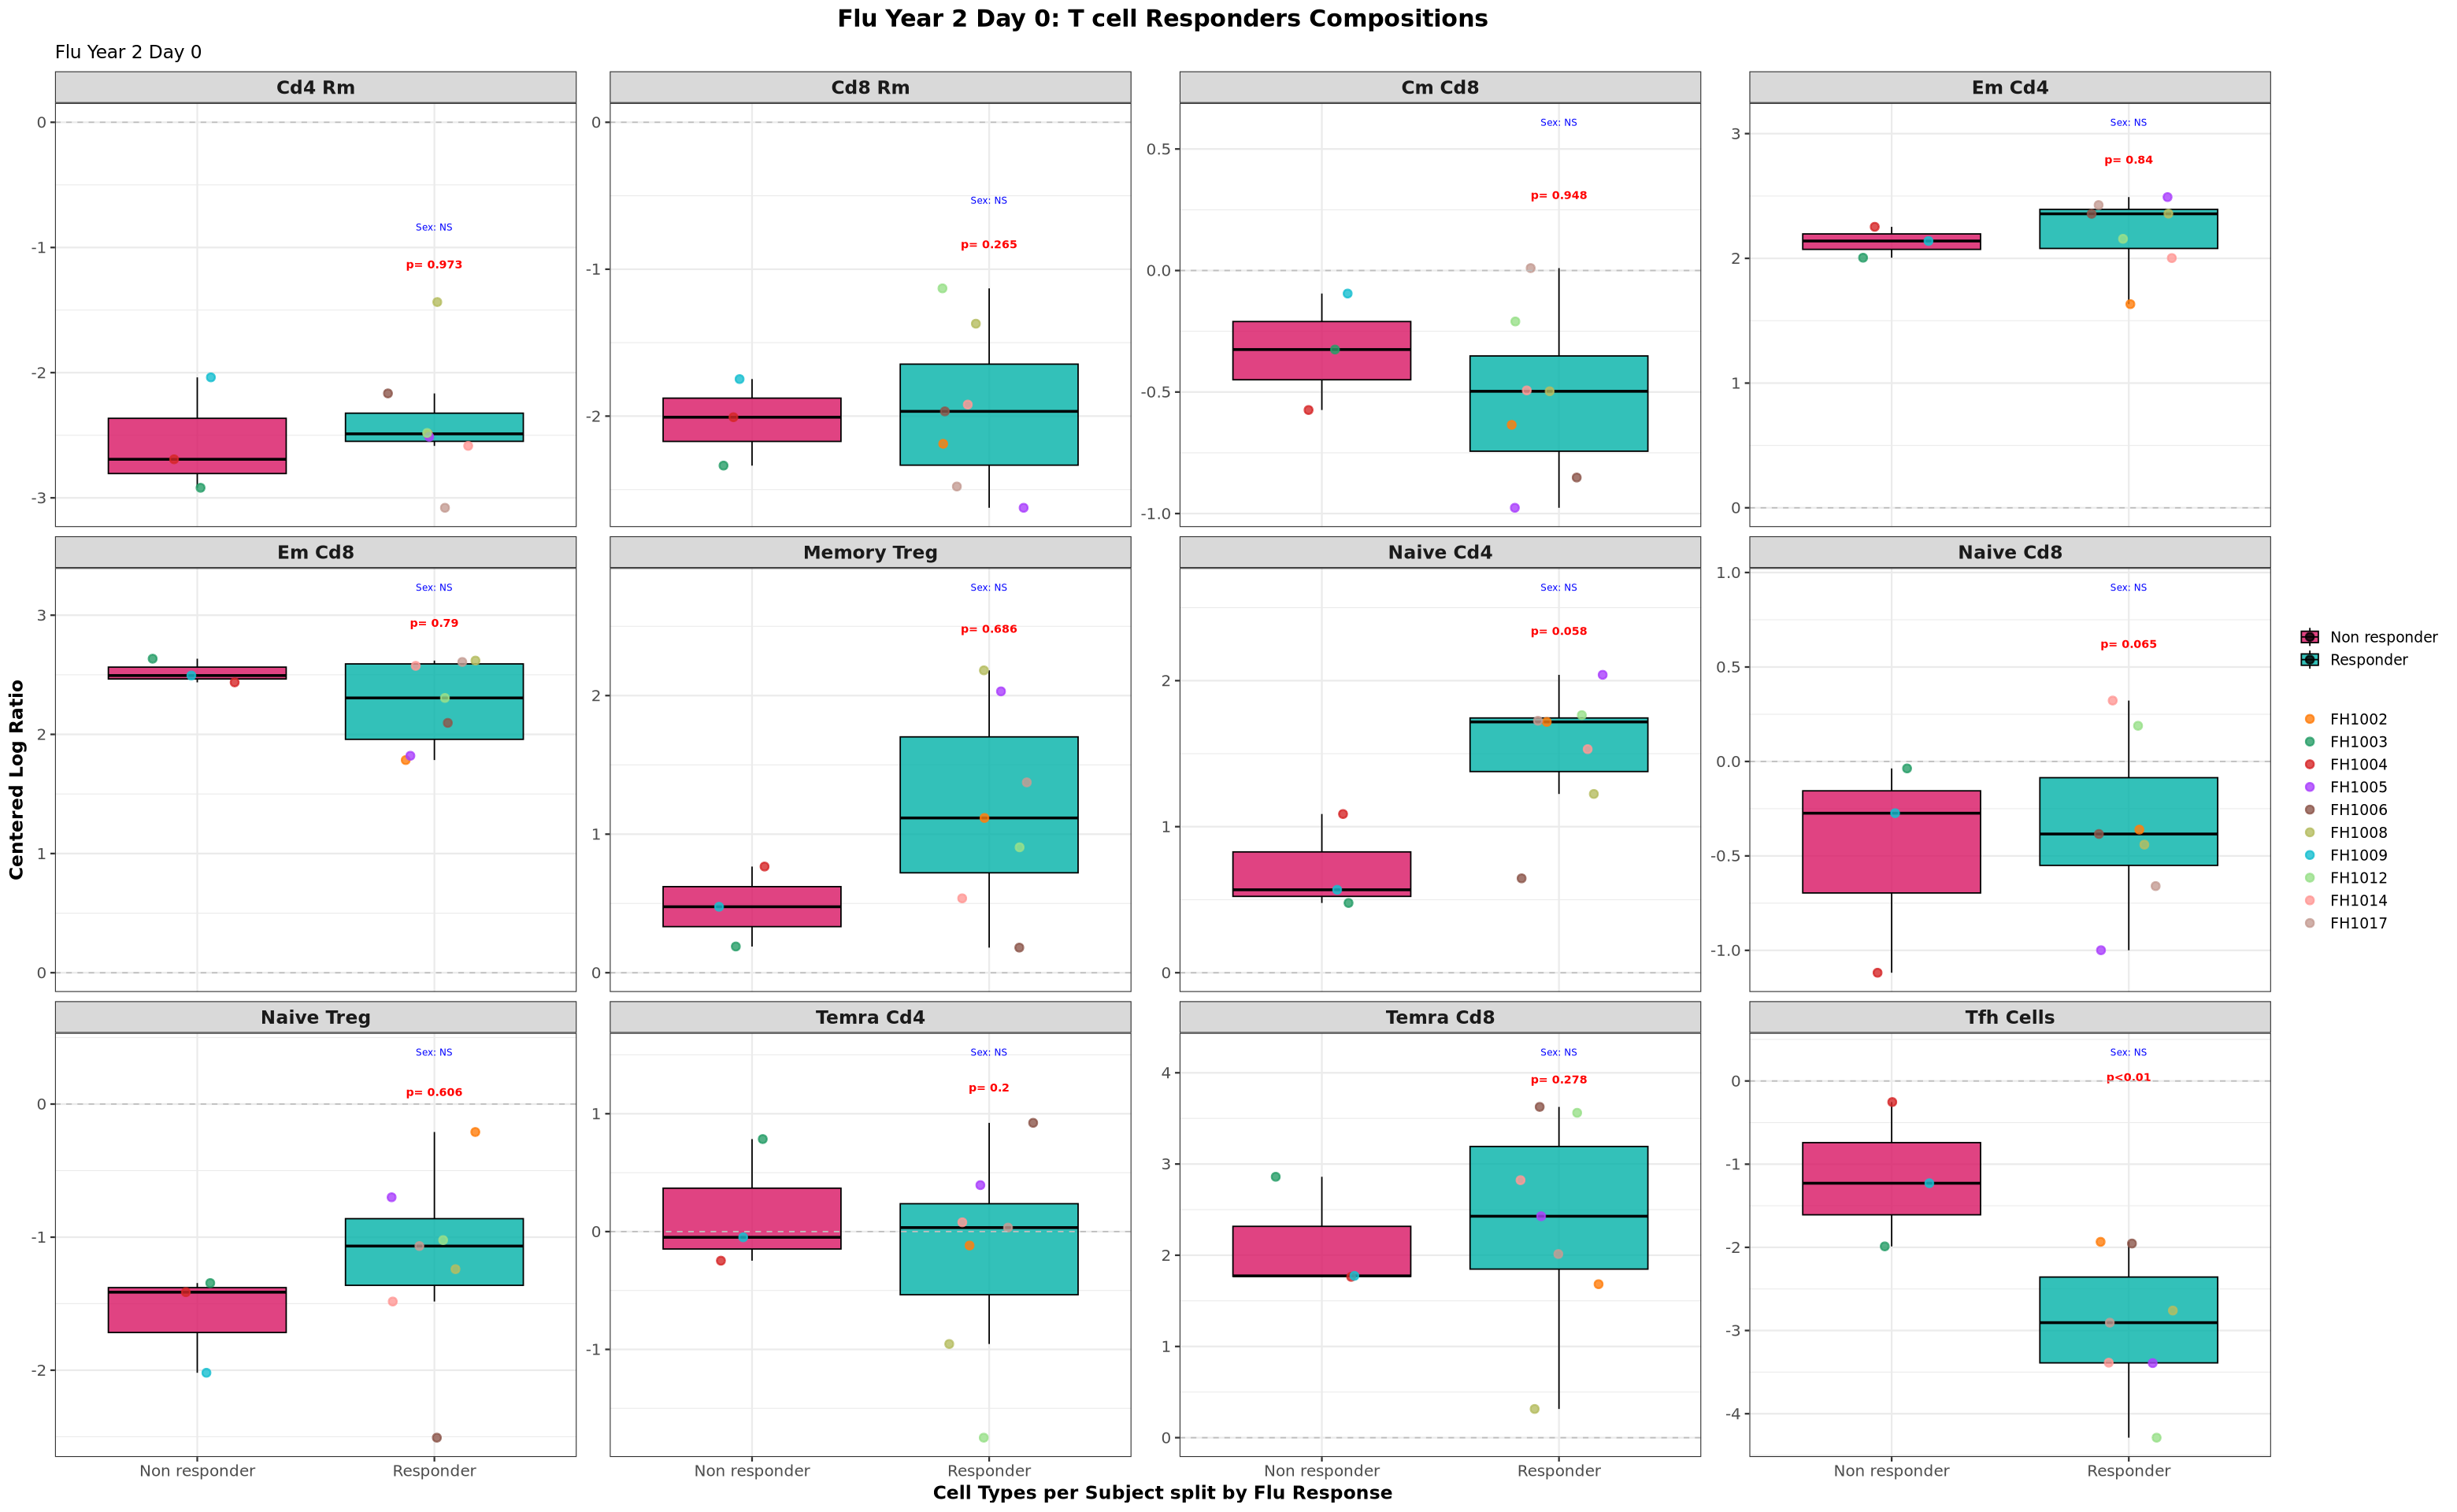


$`Flu Year 2 Day 90`


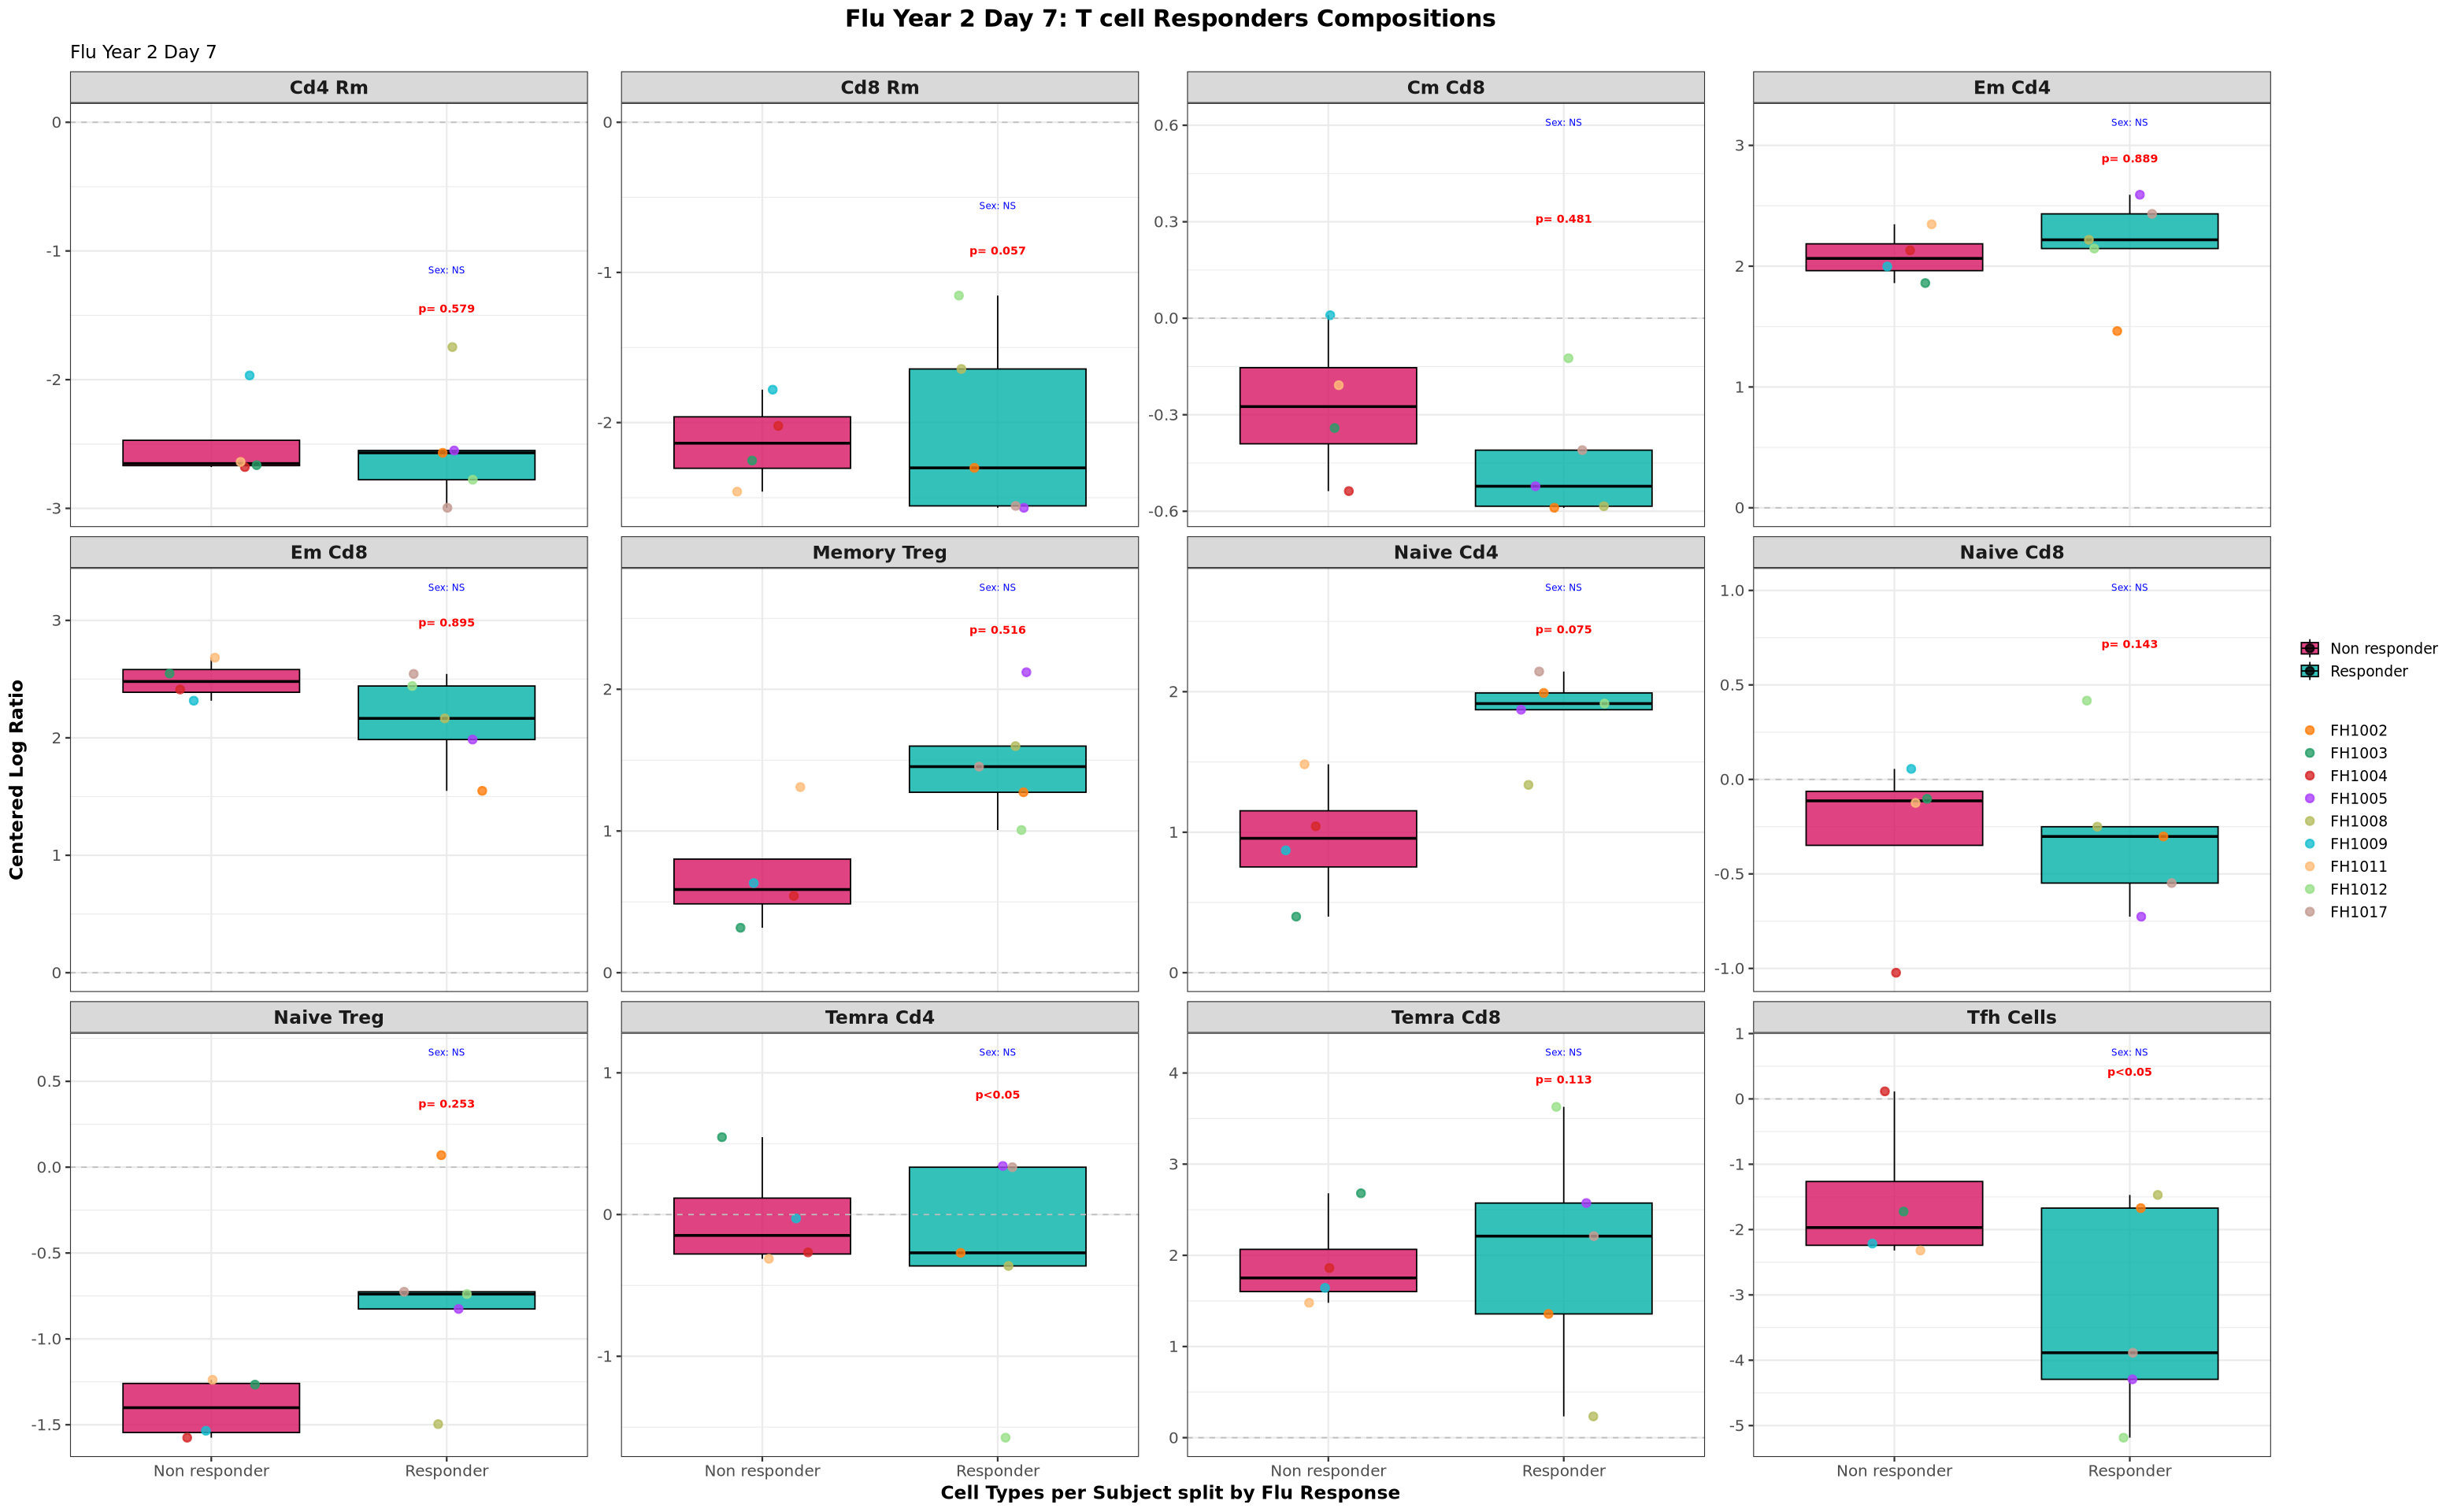

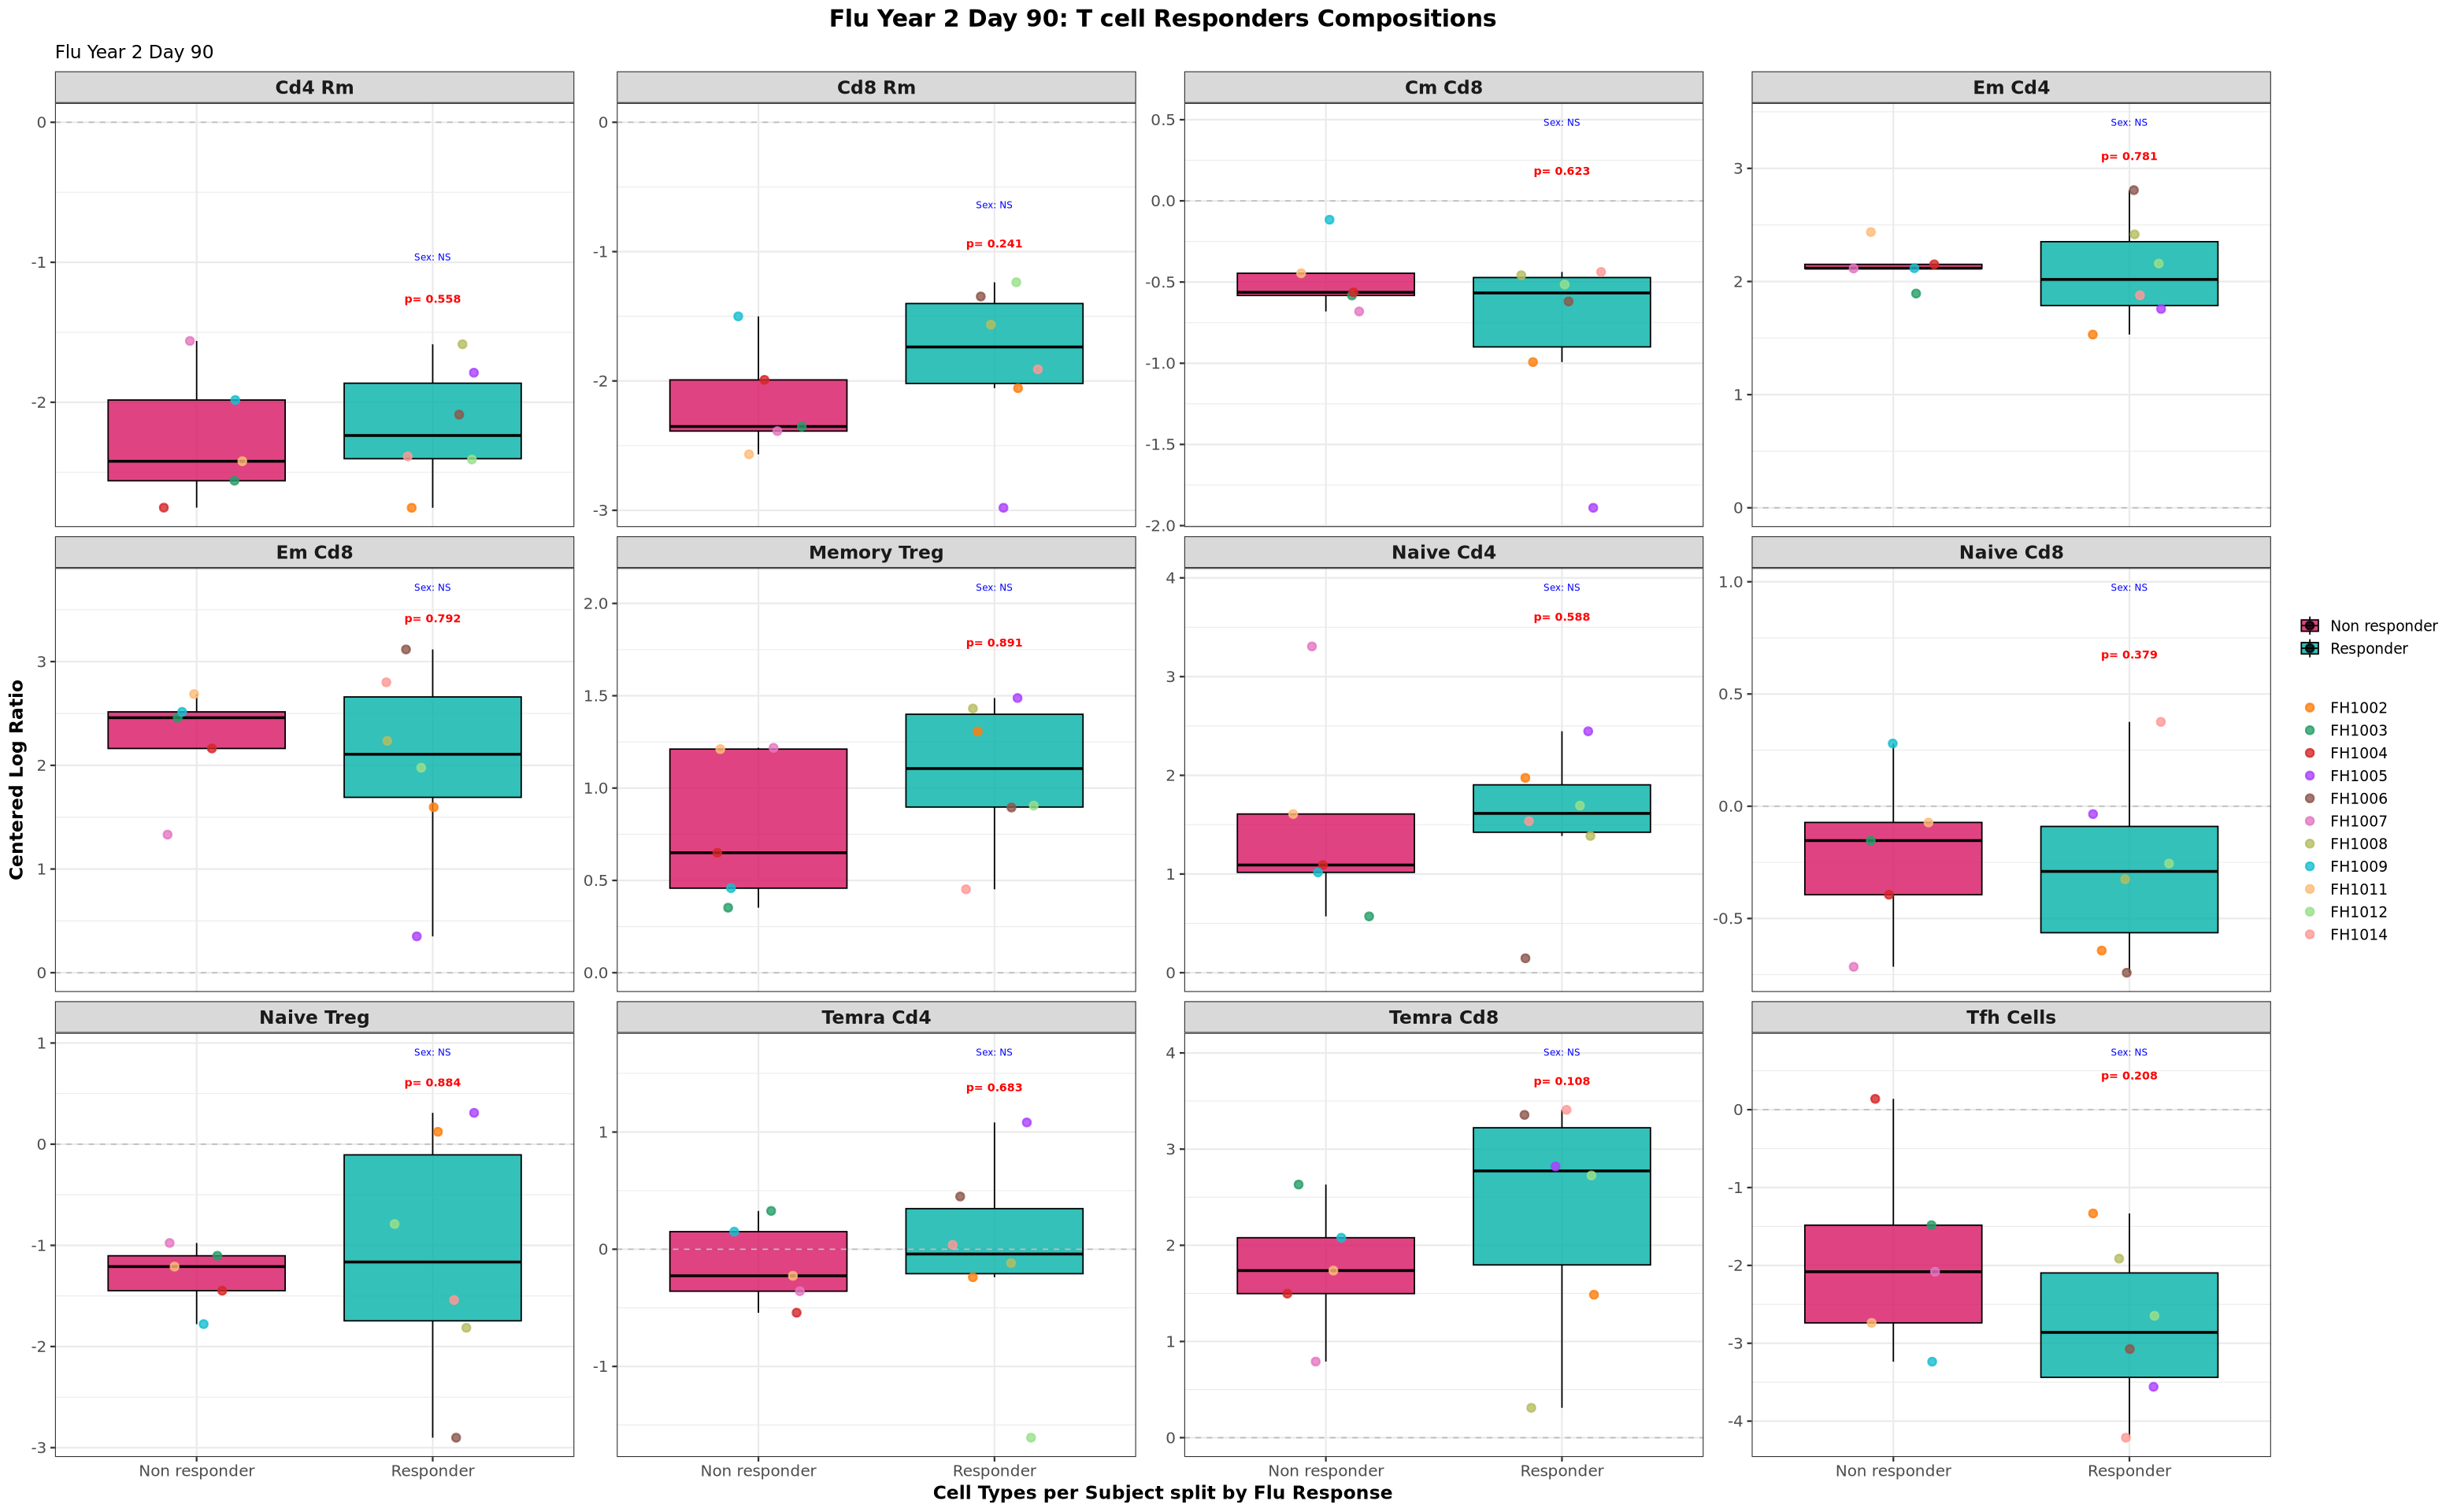

In [3]:
options(repr.plot.width = 26, repr.plot.height = 16)

plot_celltype_clr <- function(
    input_csv,
    treatment_label,
    celltype_level,
    title,
    subtitle,
    file_save_name = "boxplot",
    color_map = c(
      "FH1001" = "#1f77b4", "FH1002" = "#ff7f0e", "FH1003" = "#279e68",
      "FH1004" = "#d62728", "FH1005" = "#aa40fc", "FH1006" = "#8c564b",
      "FH1007" = "#e377c2", "FH1008" = "#b5bd61", "FH1009" = "#17becf",
      "FH1010" = "#aec7e8", "FH1011" = "#ffbb78", "FH1012" = "#98df8a",
      "FH1014" = "#ff9896", "FH1016" = "#c5b0d5", "FH1017" = "#c49c94",
      "FH1018" = "#f7b6d2", "FH1021" = "#dbdb8d"
    )) {
  
  # Read and filter data
  frequency_plots <- fread(input_csv)
  frequency_plots <- frequency_plots[Flu.Visit == treatment_label]
  frequency_plots <- frequency_plots[Response != ""]
  frequency_plots$facet_label <- stringr::str_to_title(gsub("_", " ", frequency_plots[[celltype_level]]))

  # Perform linear regression for each cell type
  cell_types <- unique(frequency_plots[[celltype_level]])
  regression_results <- data.frame()
  
  for (celltype in cell_types) {
    subset_data <- frequency_plots[frequency_plots[[celltype_level]] == celltype, ]
    
    if (nrow(subset_data) > 3) {
      model <- lm(frequency_clr ~ Sex + Response, data = subset_data)
      model_summary <- summary(model)
      
      response_pval <- model_summary$coefficients["ResponseResponder", "Pr(>|t|)"]
      sex_pval <- if("SexM" %in% rownames(model_summary$coefficients)) {
        model_summary$coefficients["SexM", "Pr(>|t|)"]
      } else { NA }
      
      regression_results <- rbind(regression_results, data.frame(
        celltype = celltype,
        facet_label = stringr::str_to_title(gsub("_", " ", celltype)),
        response_pval = response_pval,
        sex_pval = sex_pval,
        response_coeff = model_summary$coefficients["ResponseResponder", "Estimate"],
        adj_r_squared = model_summary$adj.r.squared
      ))
    }
  }
  
  # Format p-values
  regression_results$response_p_text <- ifelse(
    regression_results$response_pval < 0.001, "p<0.001",
    ifelse(regression_results$response_pval < 0.01, "p<0.01",
           ifelse(regression_results$response_pval < 0.05, "p<0.05", 
                  paste("p=", round(regression_results$response_pval, 3))))
  )
  
  regression_results$sex_p_text <- ifelse(
    is.na(regression_results$sex_pval), "Sex: NS",
    ifelse(regression_results$sex_pval < 0.001, "Sex: p<0.001",
           ifelse(regression_results$sex_pval < 0.01, "Sex: p<0.01",
                  ifelse(regression_results$sex_pval < 0.05, "Sex: p<0.05", 
                         paste("Sex: p=", round(regression_results$sex_pval, 3)))))
  )

  # Calculate y positions for annotations
  max_y <- aggregate(frequency_clr ~ facet_label, data = frequency_plots, max)
  regression_results <- merge(regression_results, max_y, by = "facet_label")
  regression_results$y_response <- regression_results$frequency_clr + 0.3
  regression_results$y_sex <- regression_results$frequency_clr + 0.6

  height <- ceiling(length(unique(frequency_plots[[celltype_level]])) / 4) * 7

  # Create plot
  p <- ggplot(frequency_plots, aes(x = Response, y = frequency_clr, fill = Response)) +
    geom_boxplot(alpha = 0.8, outlier.shape = NA, color = "black") +
    geom_jitter(aes(color = Subject), width = 0.2, size = 2.2, stroke = 1, alpha = 0.8) +
    # Add p-value annotations using geom_text
    geom_text(data = regression_results, 
              aes(x = 2, y = y_response, label = response_p_text),
              inherit.aes = FALSE, size = 3, color = "red", fontface = "bold") +
    geom_text(data = regression_results, 
              aes(x = 2, y = y_sex, label = sex_p_text),
              inherit.aes = FALSE, size = 2.5, color = "blue") +
    facet_wrap(vars(facet_label), scales = "free_y", ncol = 4) +
    labs(
      title = title,
      subtitle = subtitle,
      x = "Cell Types per Subject split by Flu Response",
      y = "Centered Log Ratio"
    ) +
    theme_bw(base_size = 14) +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 18, margin = margin(b = 10)),
      axis.title = element_text(size = 14, face = "bold"),
      axis.text = element_text(size = 12),
      legend.position = "right",
      legend.title = element_blank(),
      strip.text = element_text(size = 14, face = "bold")
    ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "gray") +
    scale_fill_manual(values = c("Responder" = "#00b2a8", "Non responder" = "#d81463")) +
    scale_color_manual(values = color_map)

  return(p)
}

timepoint_labels <- c(
    "Flu Year 1 Stand-Alone" = "Y1 SA",
    "Flu Year 1 Day 0" = "Y1 Day 0", 
    "Flu Year 1 Day 7" = "Y1 Day 7",
    "Flu Year 1 Day 90" = "Y1 Day 90",
    "Flu Year 2 Stand-Alone" = "Y2 SA",
    "Flu Year 2 Day 0" = "Y2 Day 0",
    "Flu Year 2 Day 7" = "Y2 Day 7", 
    "Flu Year 2 Day 90" = "Y2 Day 90"
)

all_regression_results <- list()

for (visit in names(timepoint_labels)) {
    
    regression_results <- plot_celltype_clr(
        input_csv = "/home/workspace/pbmc_flow/data/tcell_composition_clr_results.csv",
        treatment_label = visit,
        celltype_level = "population",
        title = paste0(visit, ": T cell Responders Compositions"),
        subtitle = visit
    )
    
    all_regression_results[[visit]] <- regression_results
}

# View regression results
print(all_regression_results)

$`Flu Year 1 Stand-Alone`

$`Flu Year 1 Day 0`


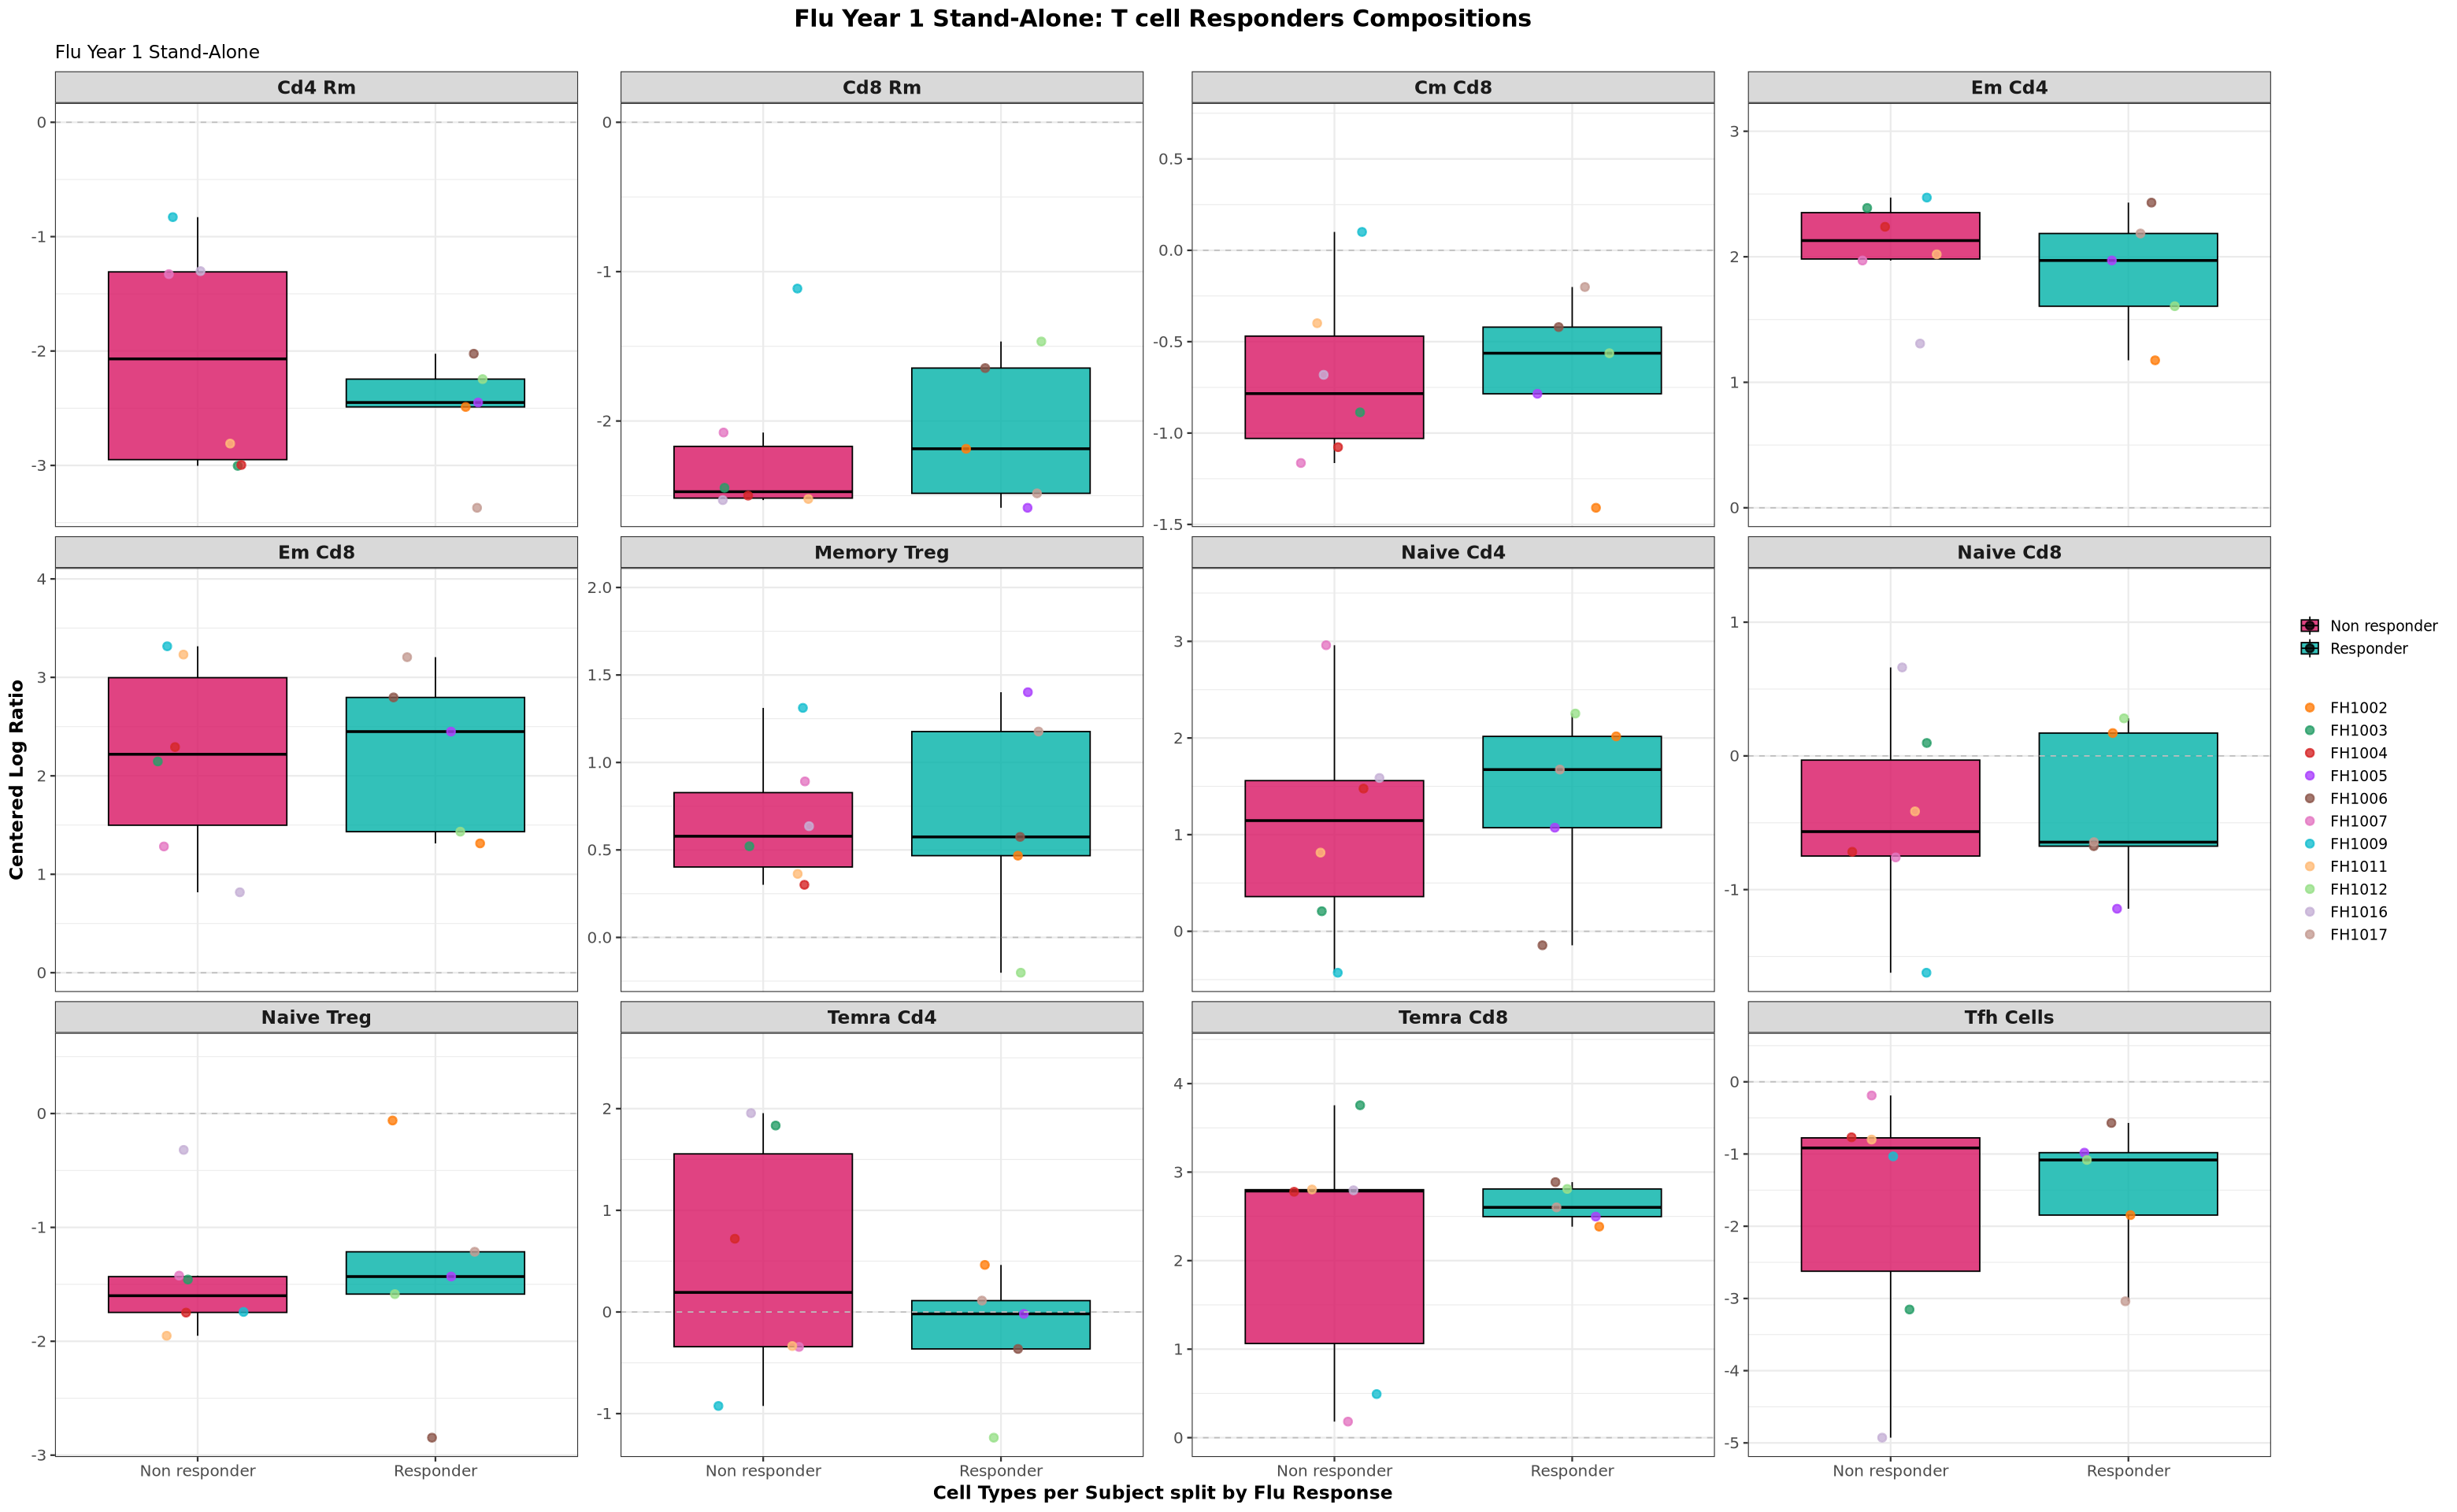


$`Flu Year 1 Day 7`


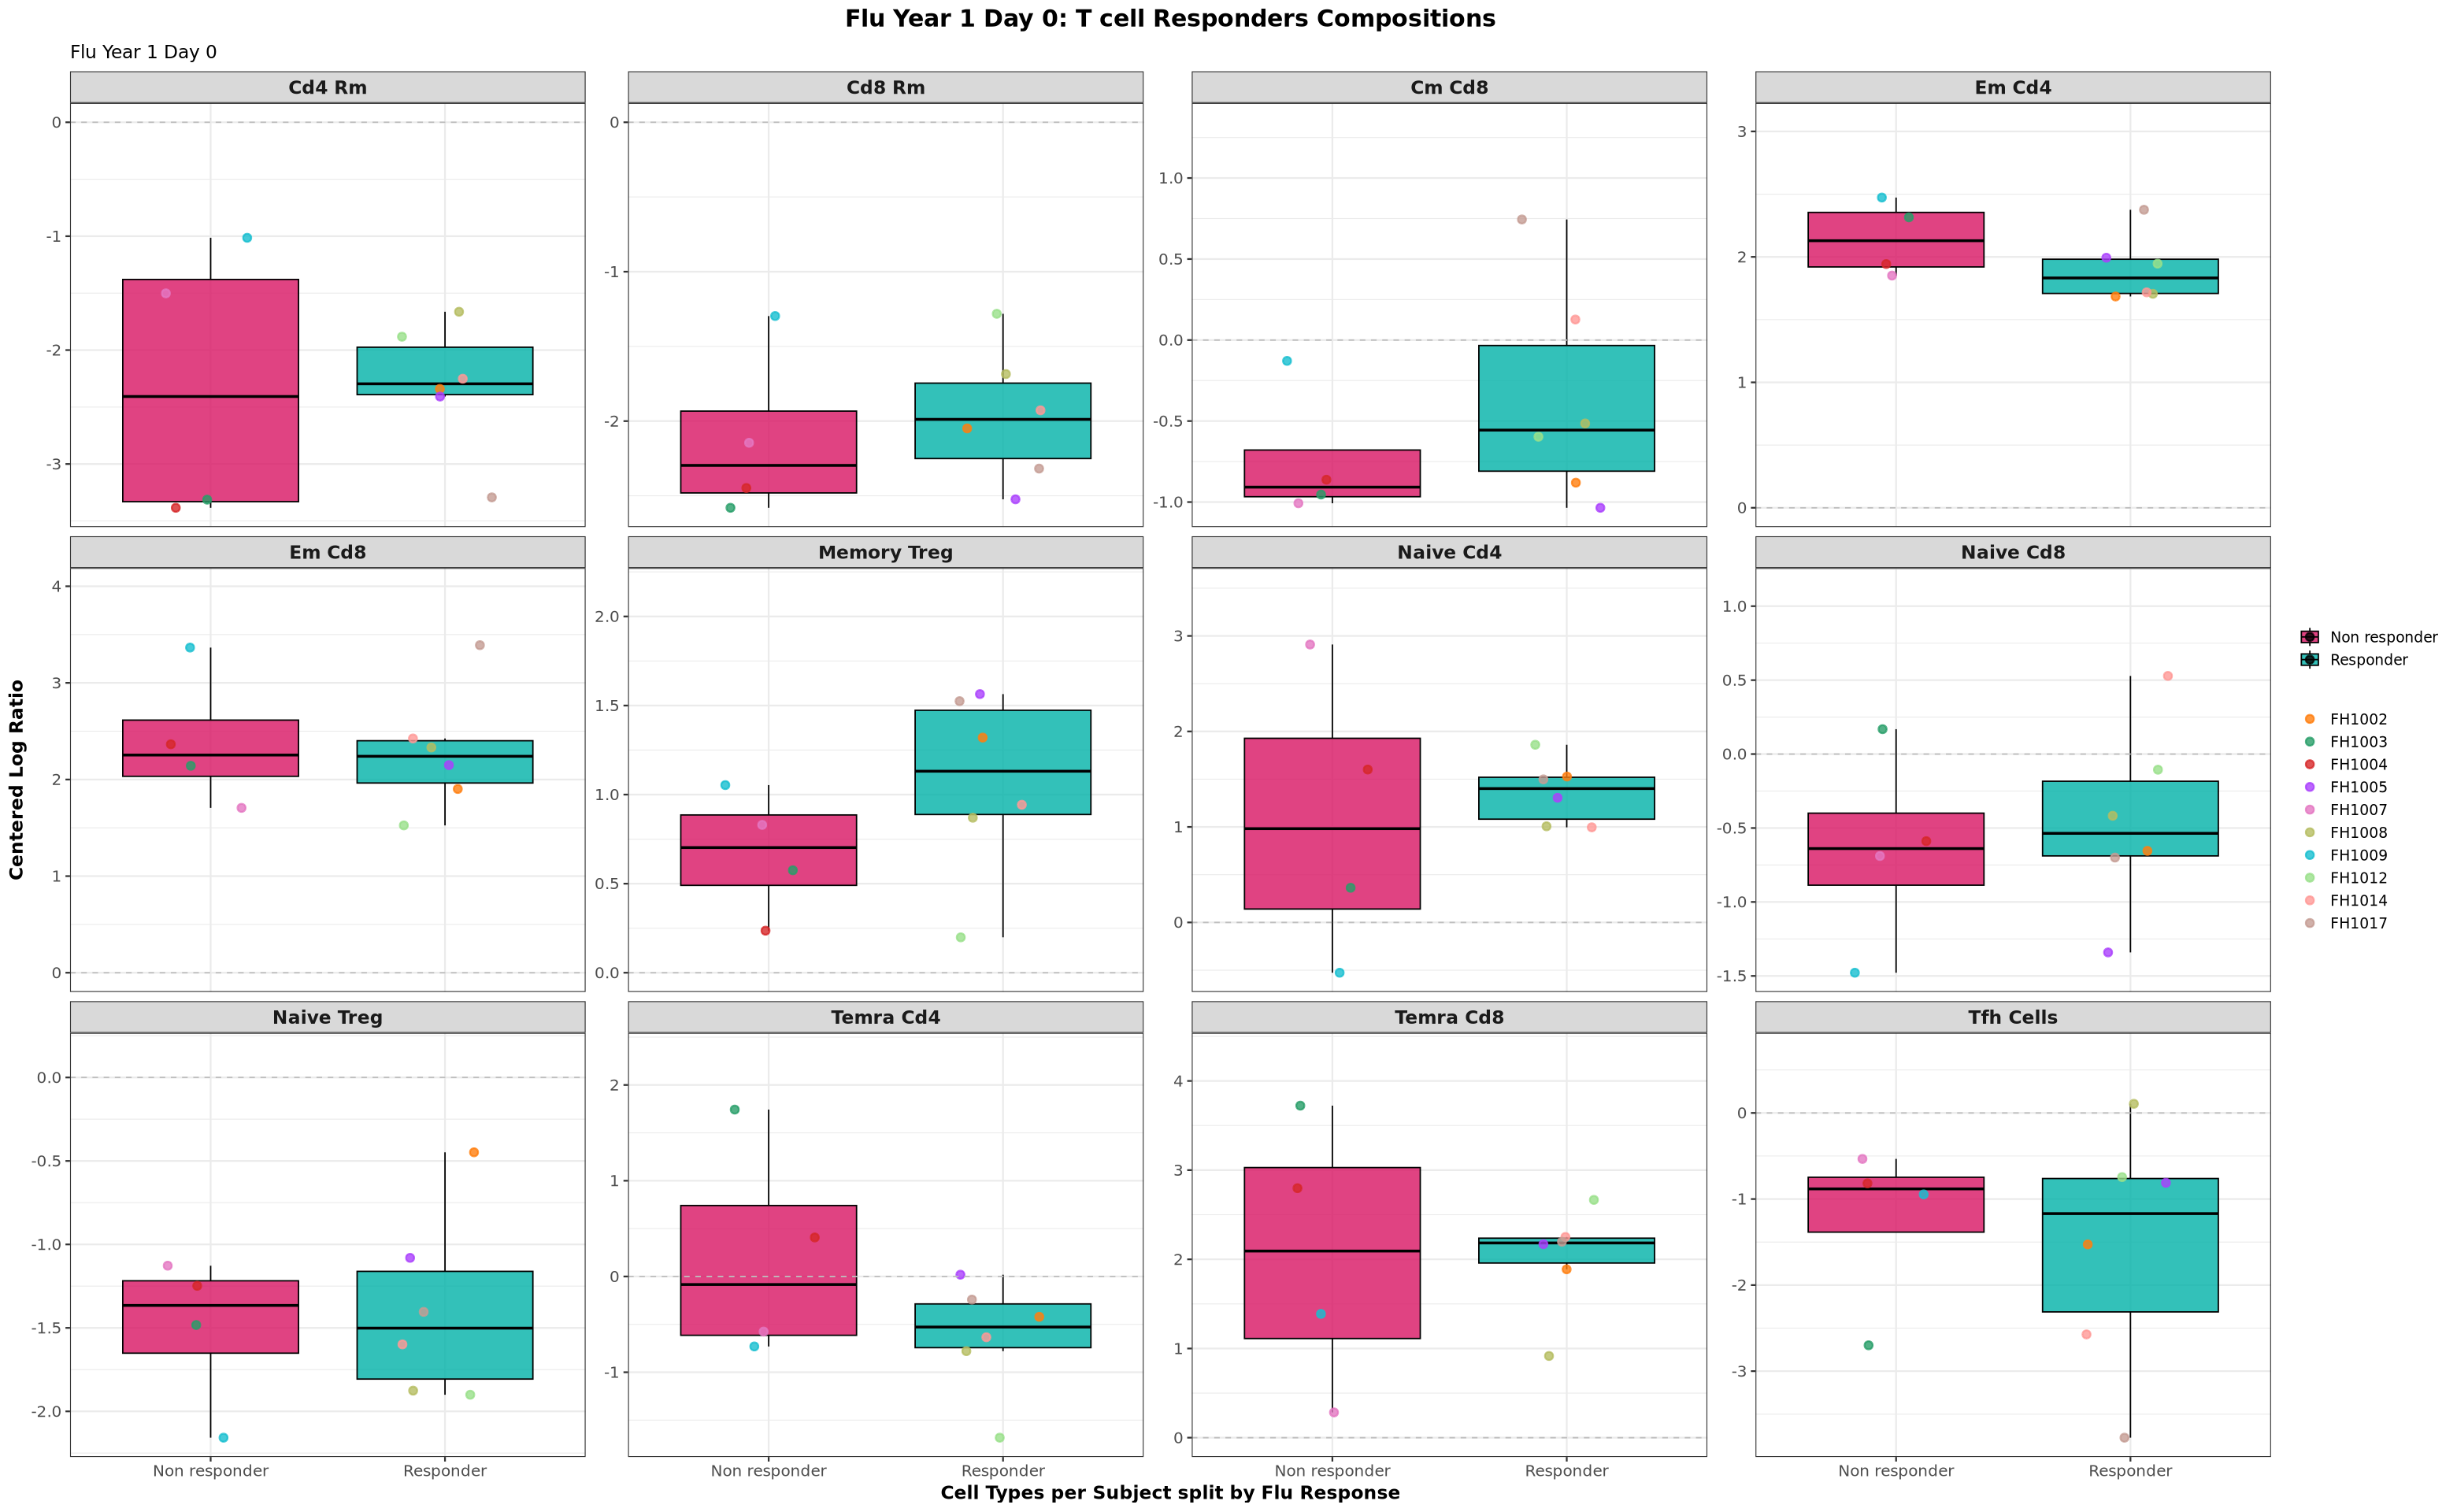


$`Flu Year 1 Day 90`


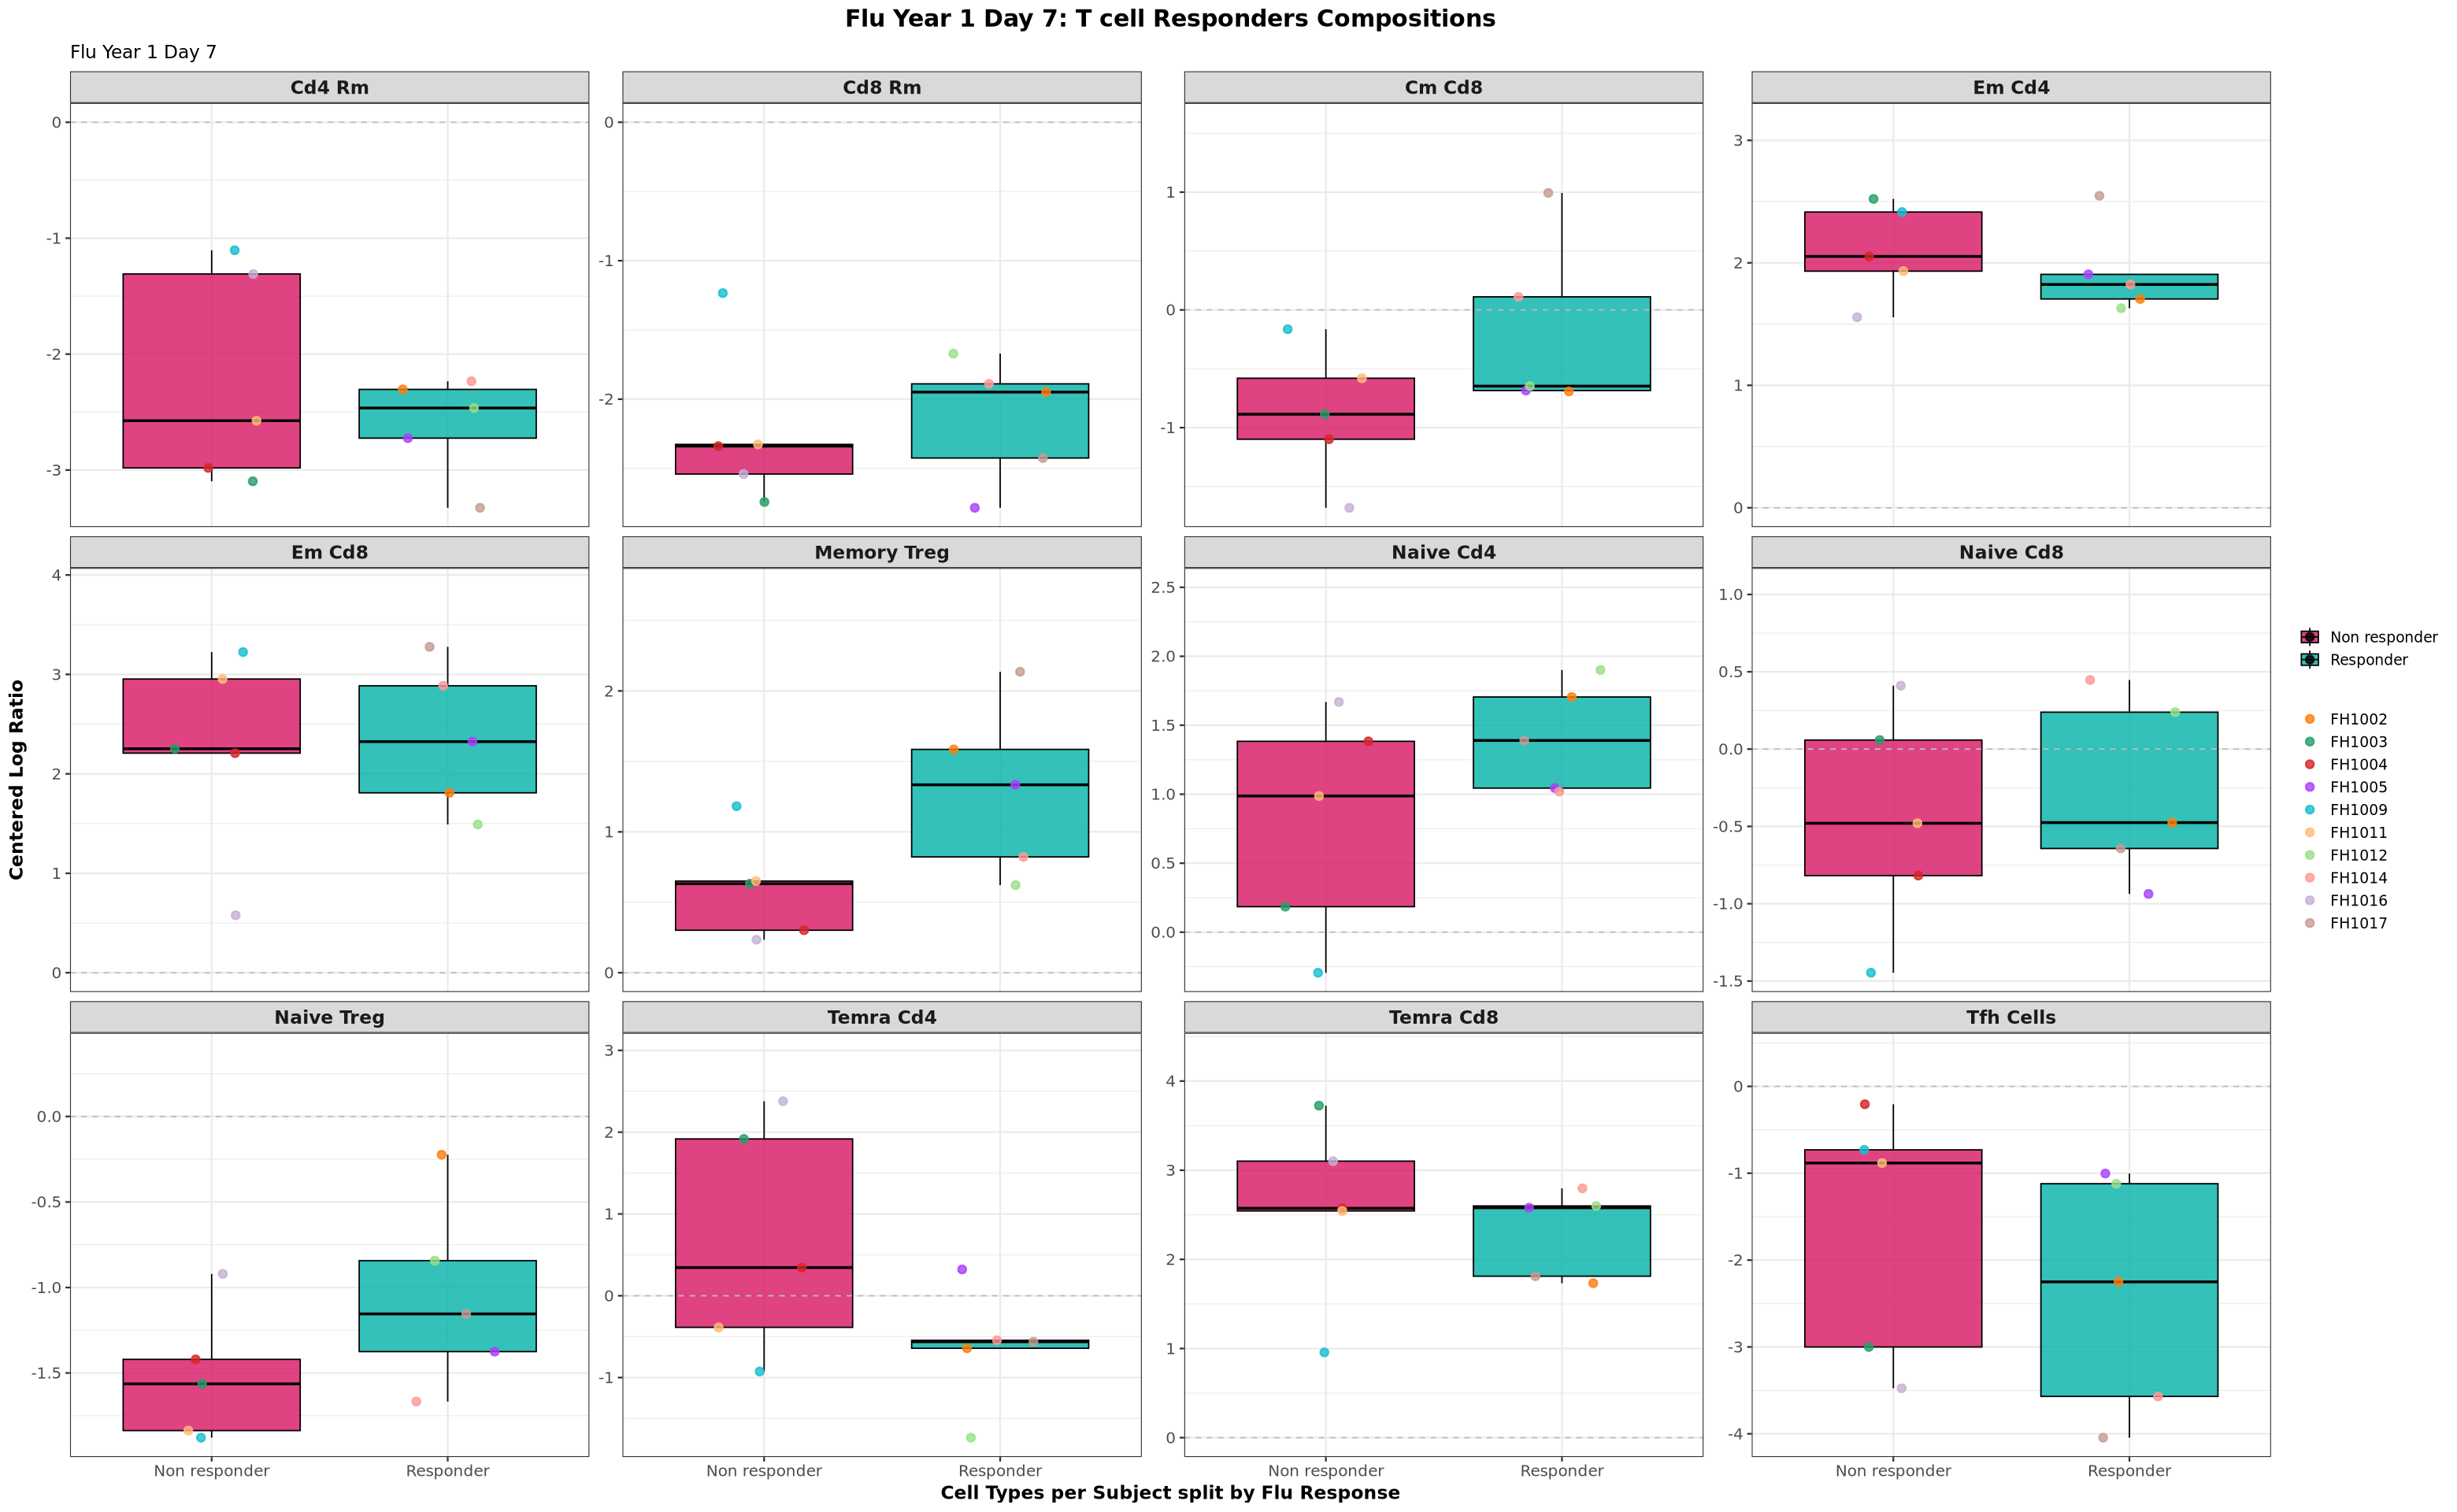


$`Flu Year 2 Stand-Alone`


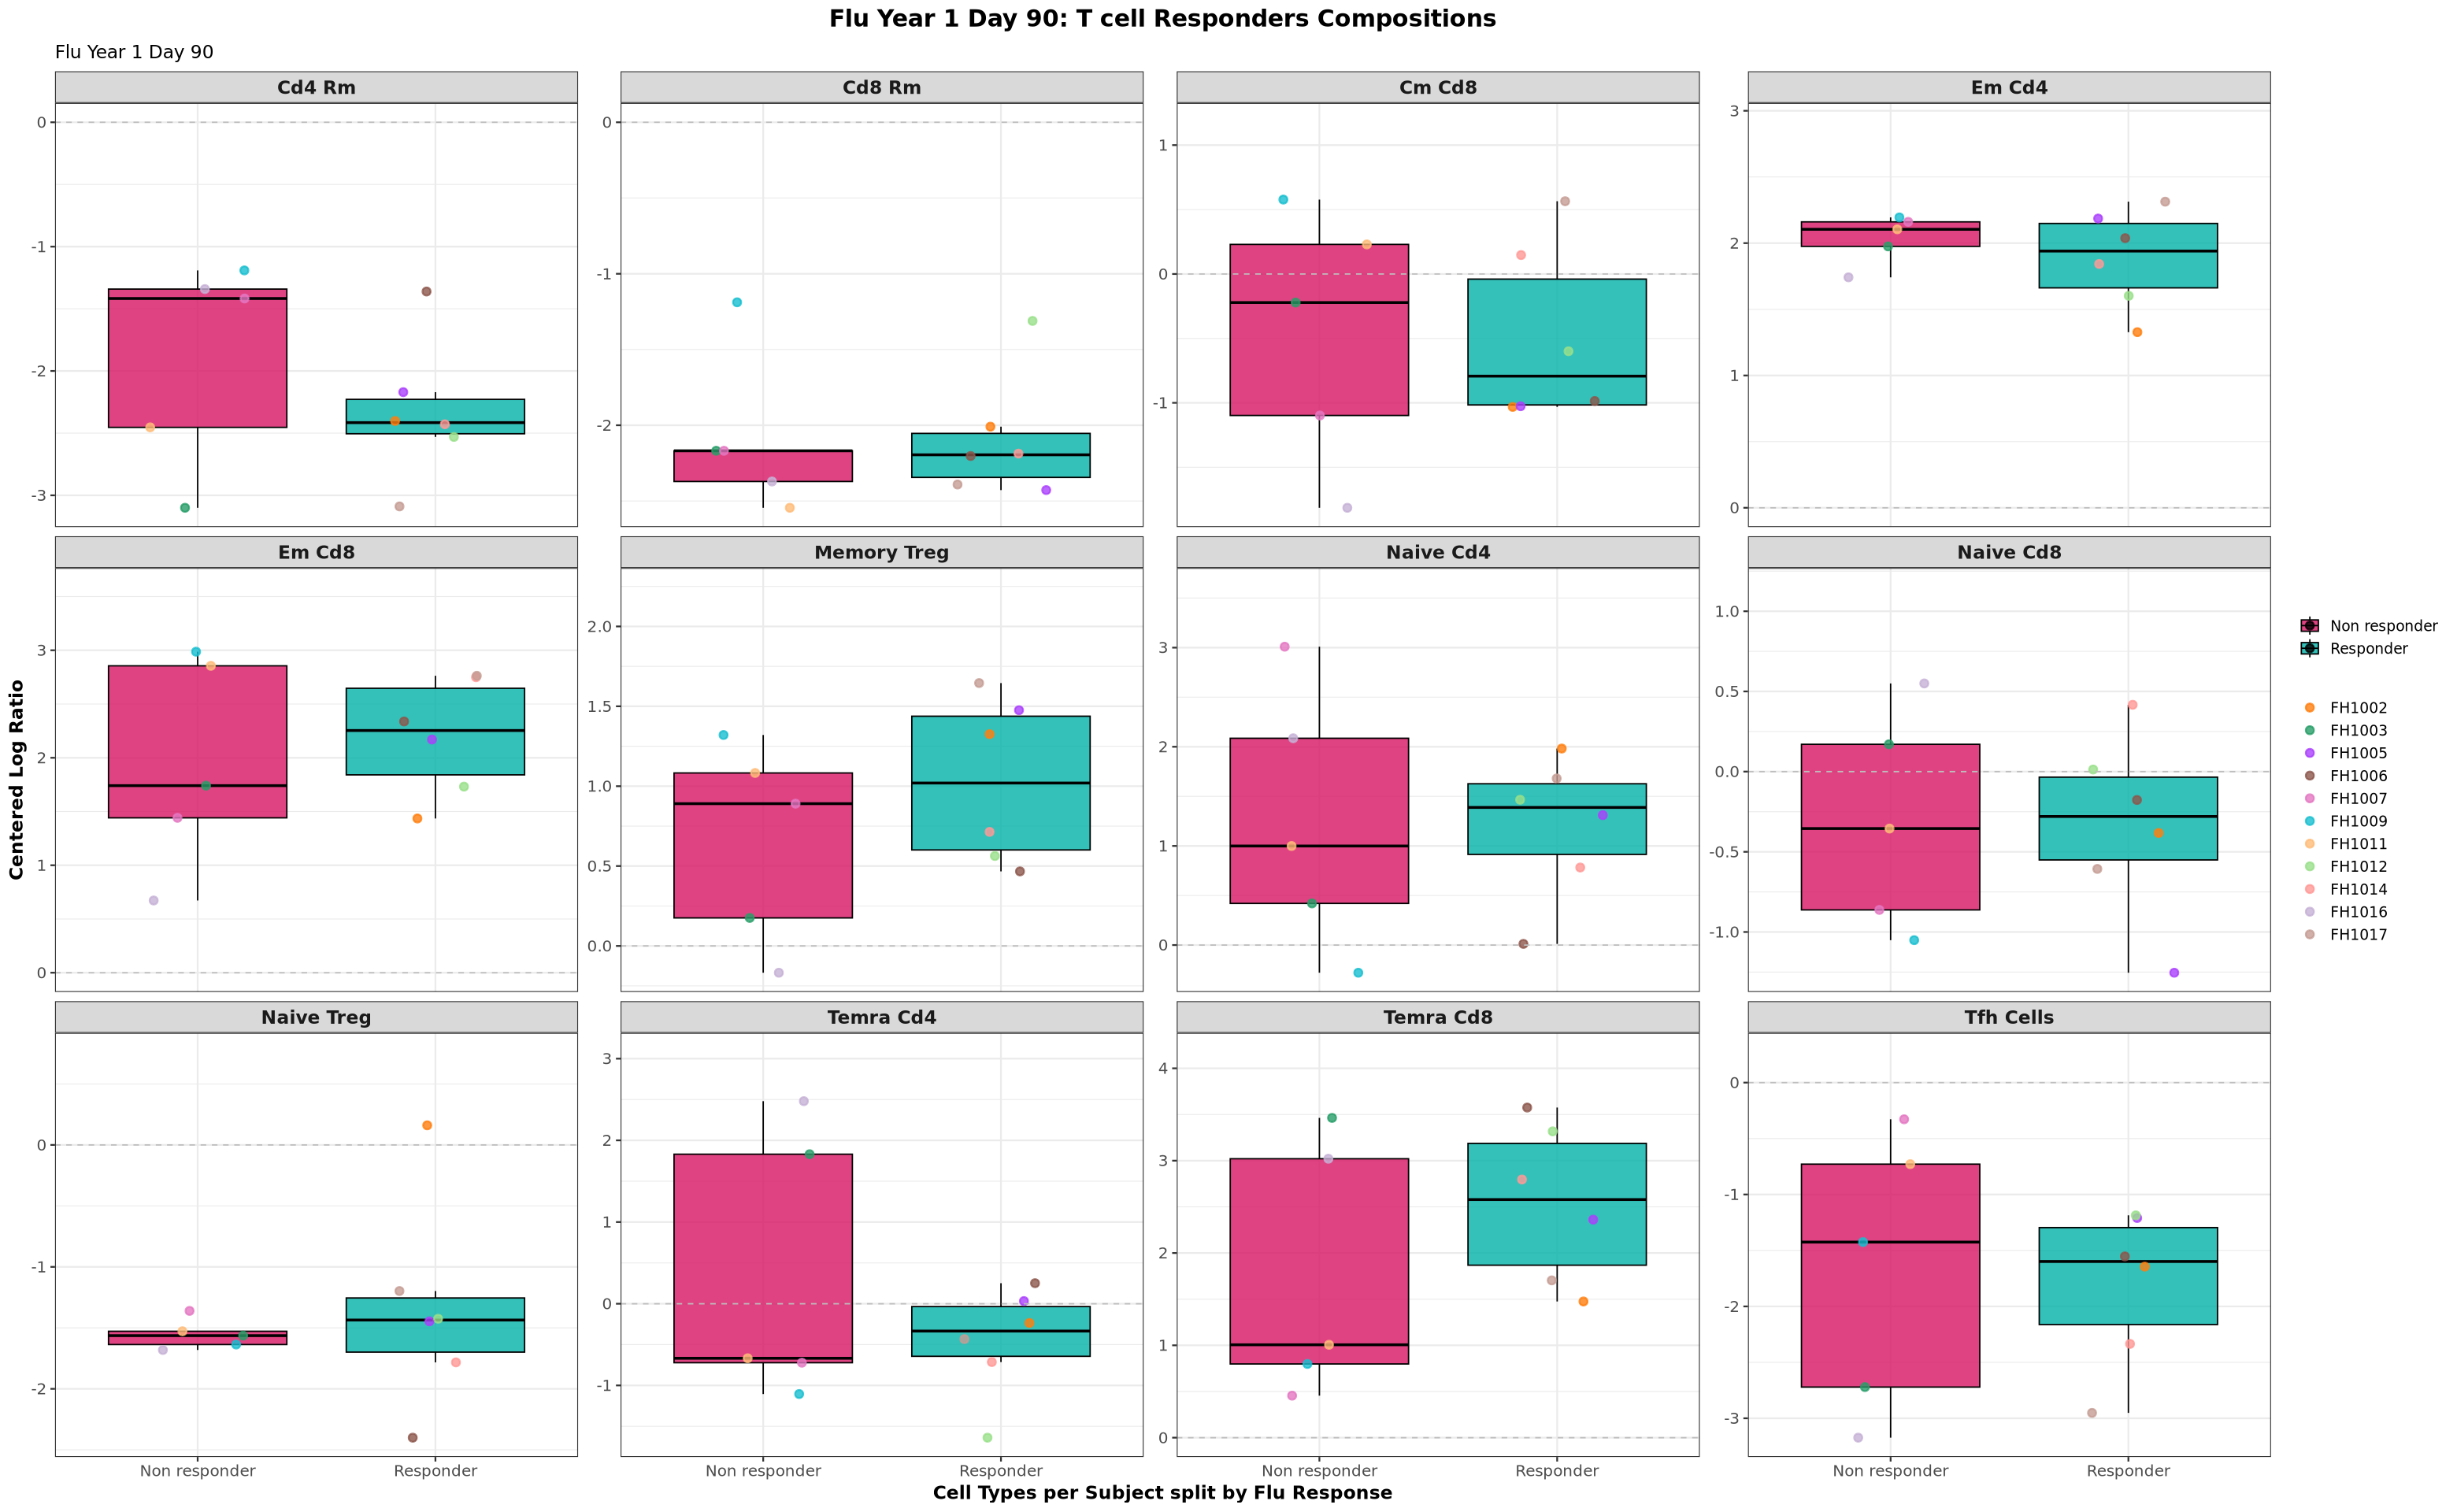


$`Flu Year 2 Day 0`


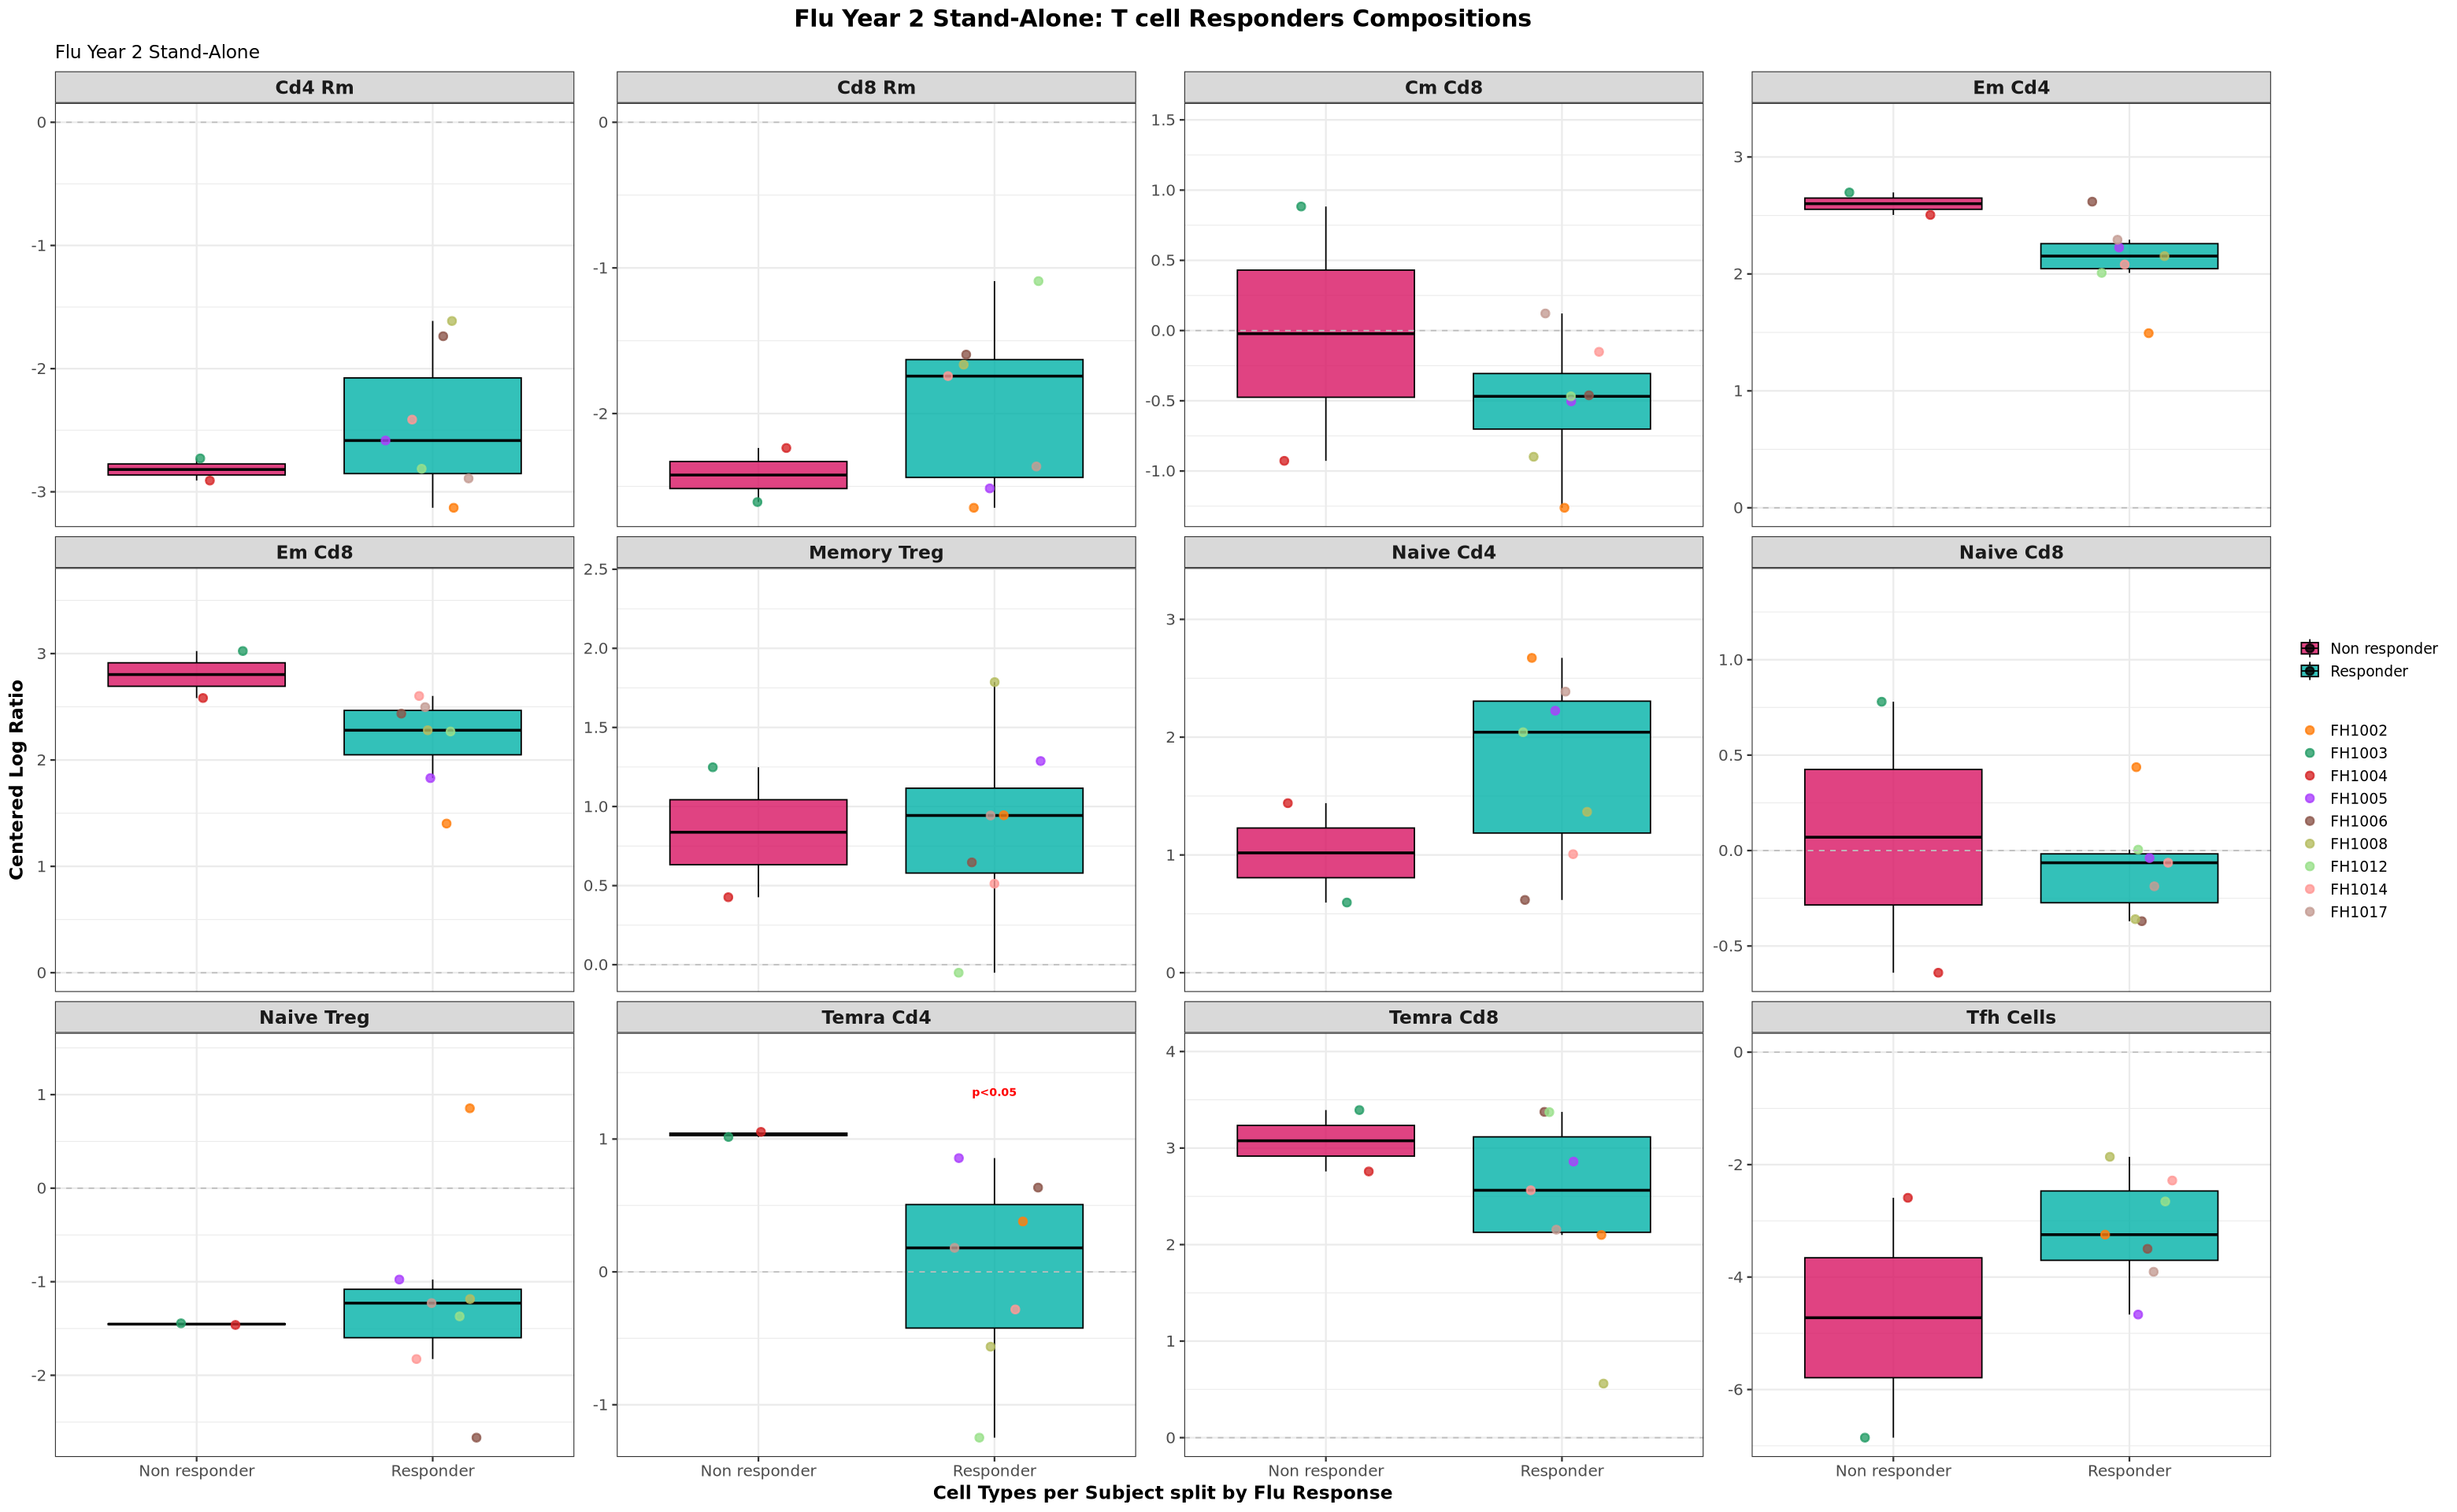


$`Flu Year 2 Day 7`


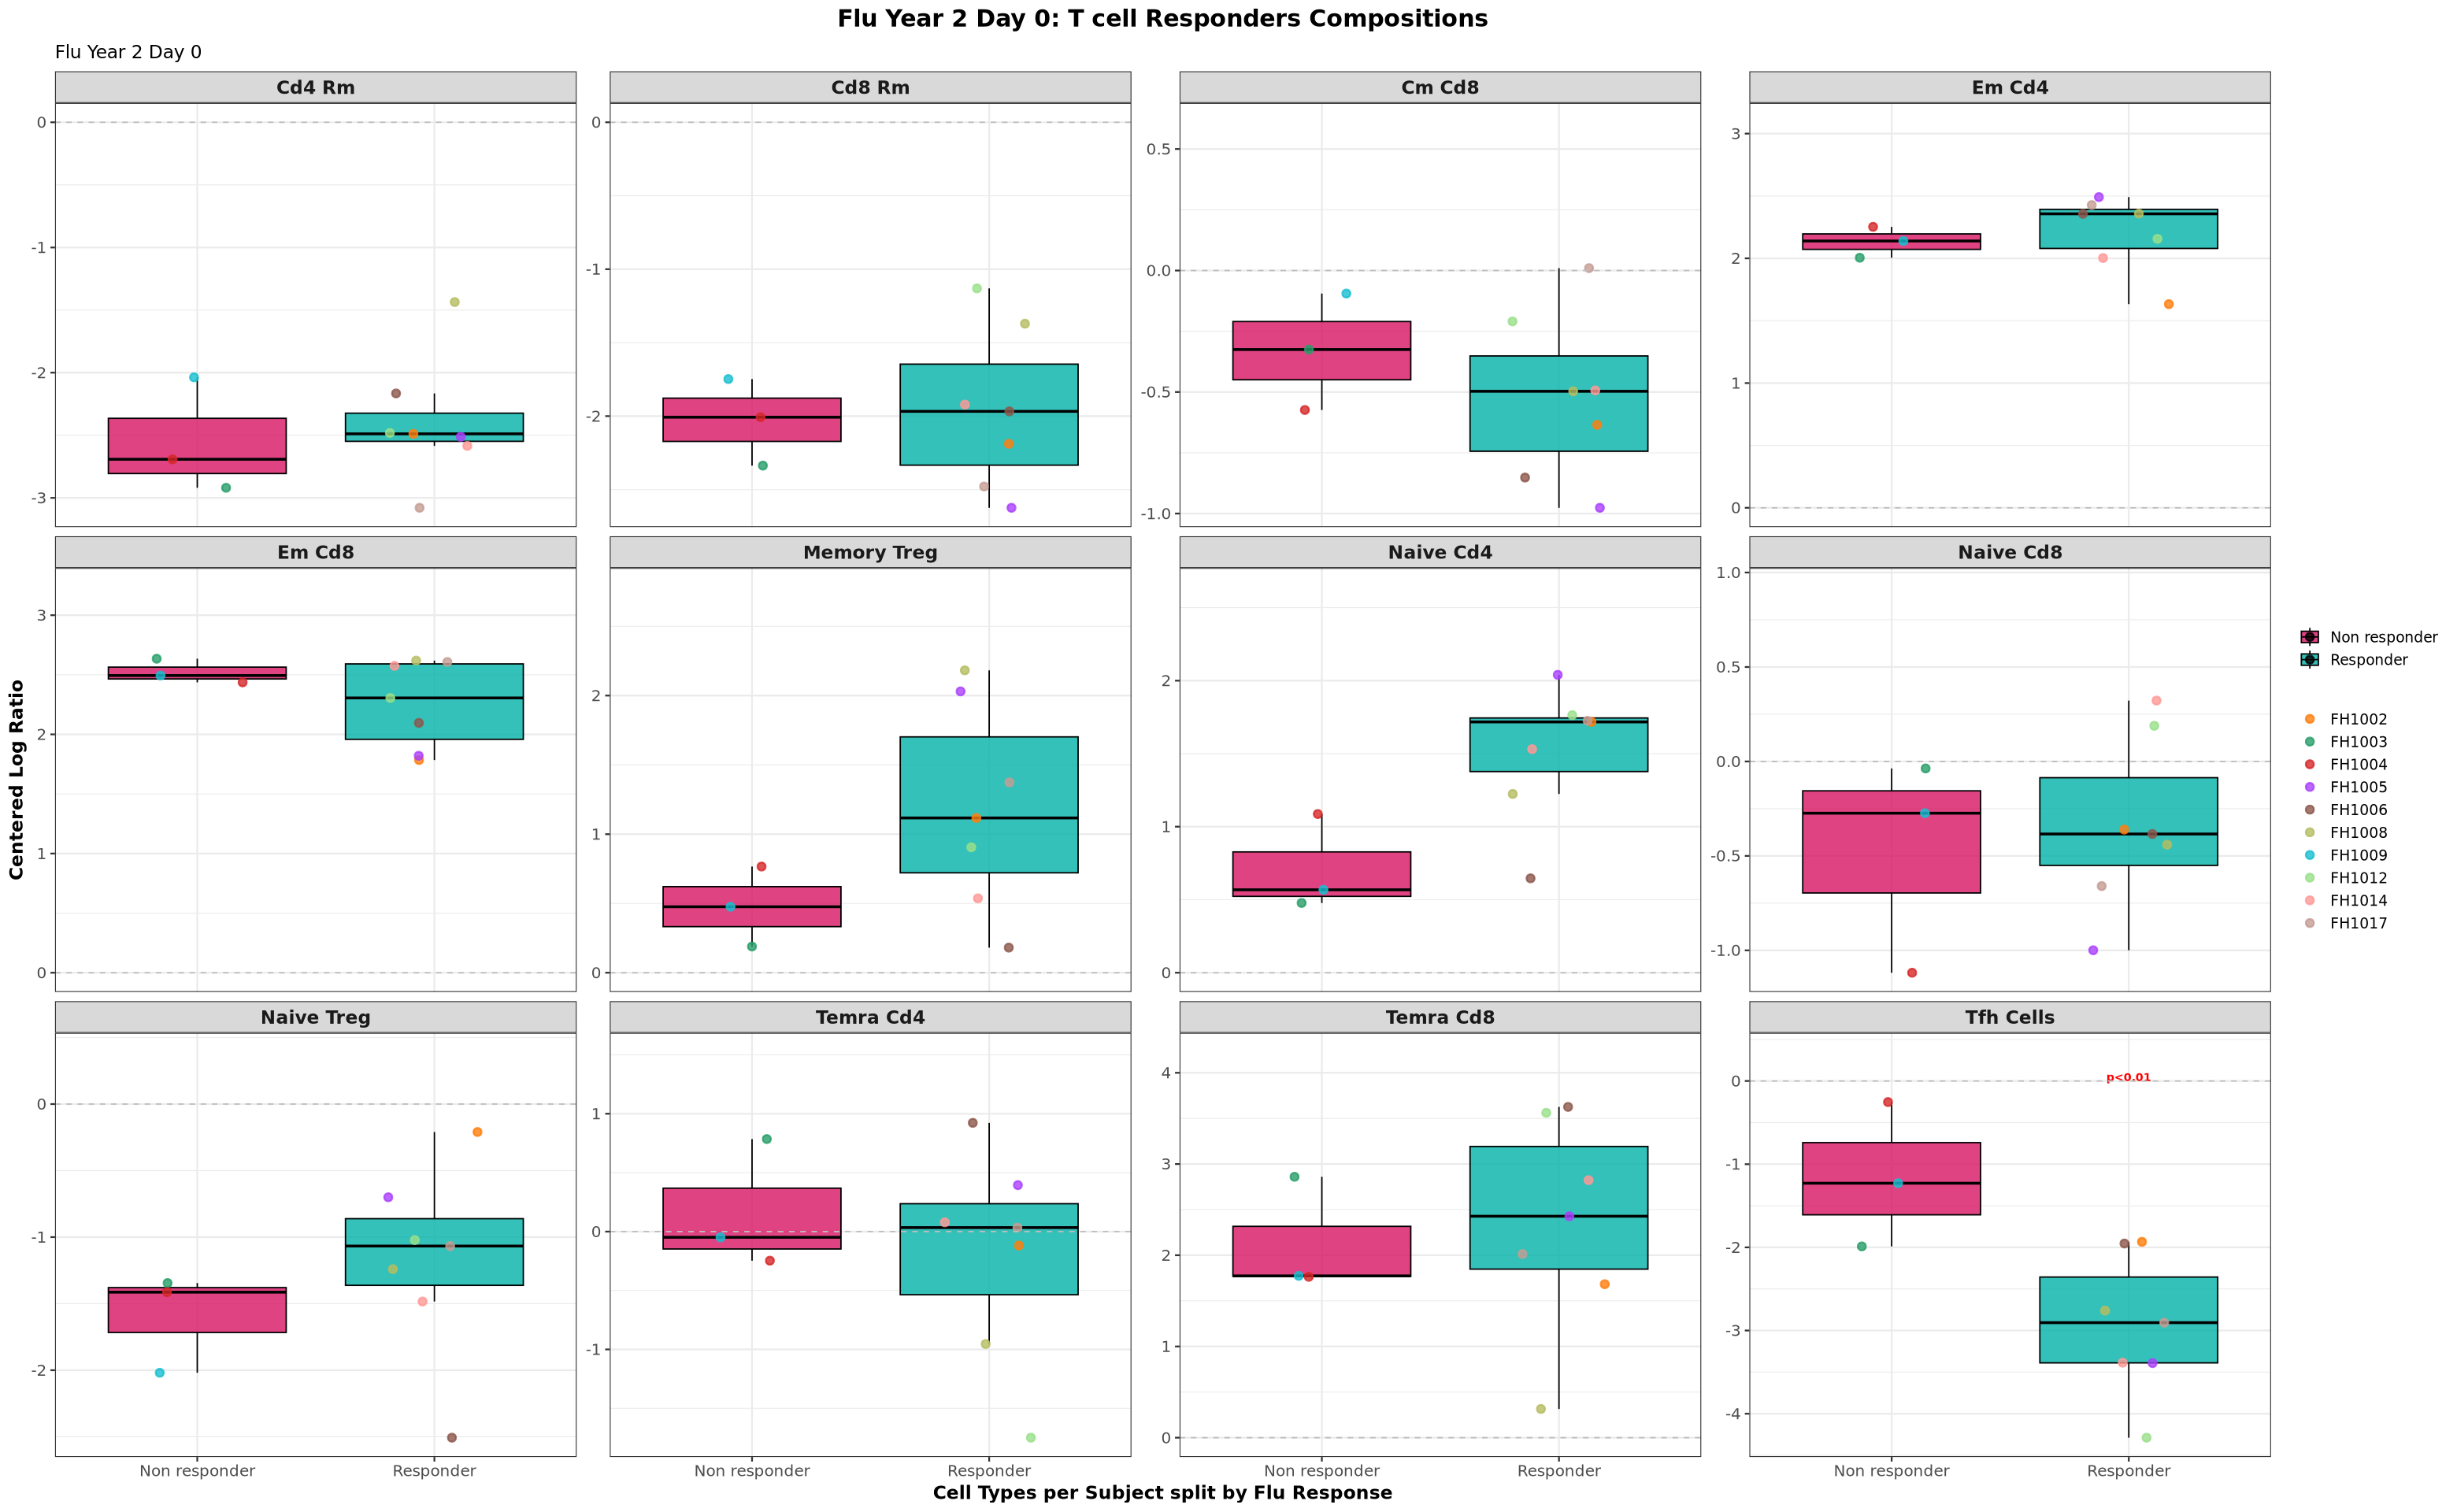


$`Flu Year 2 Day 90`


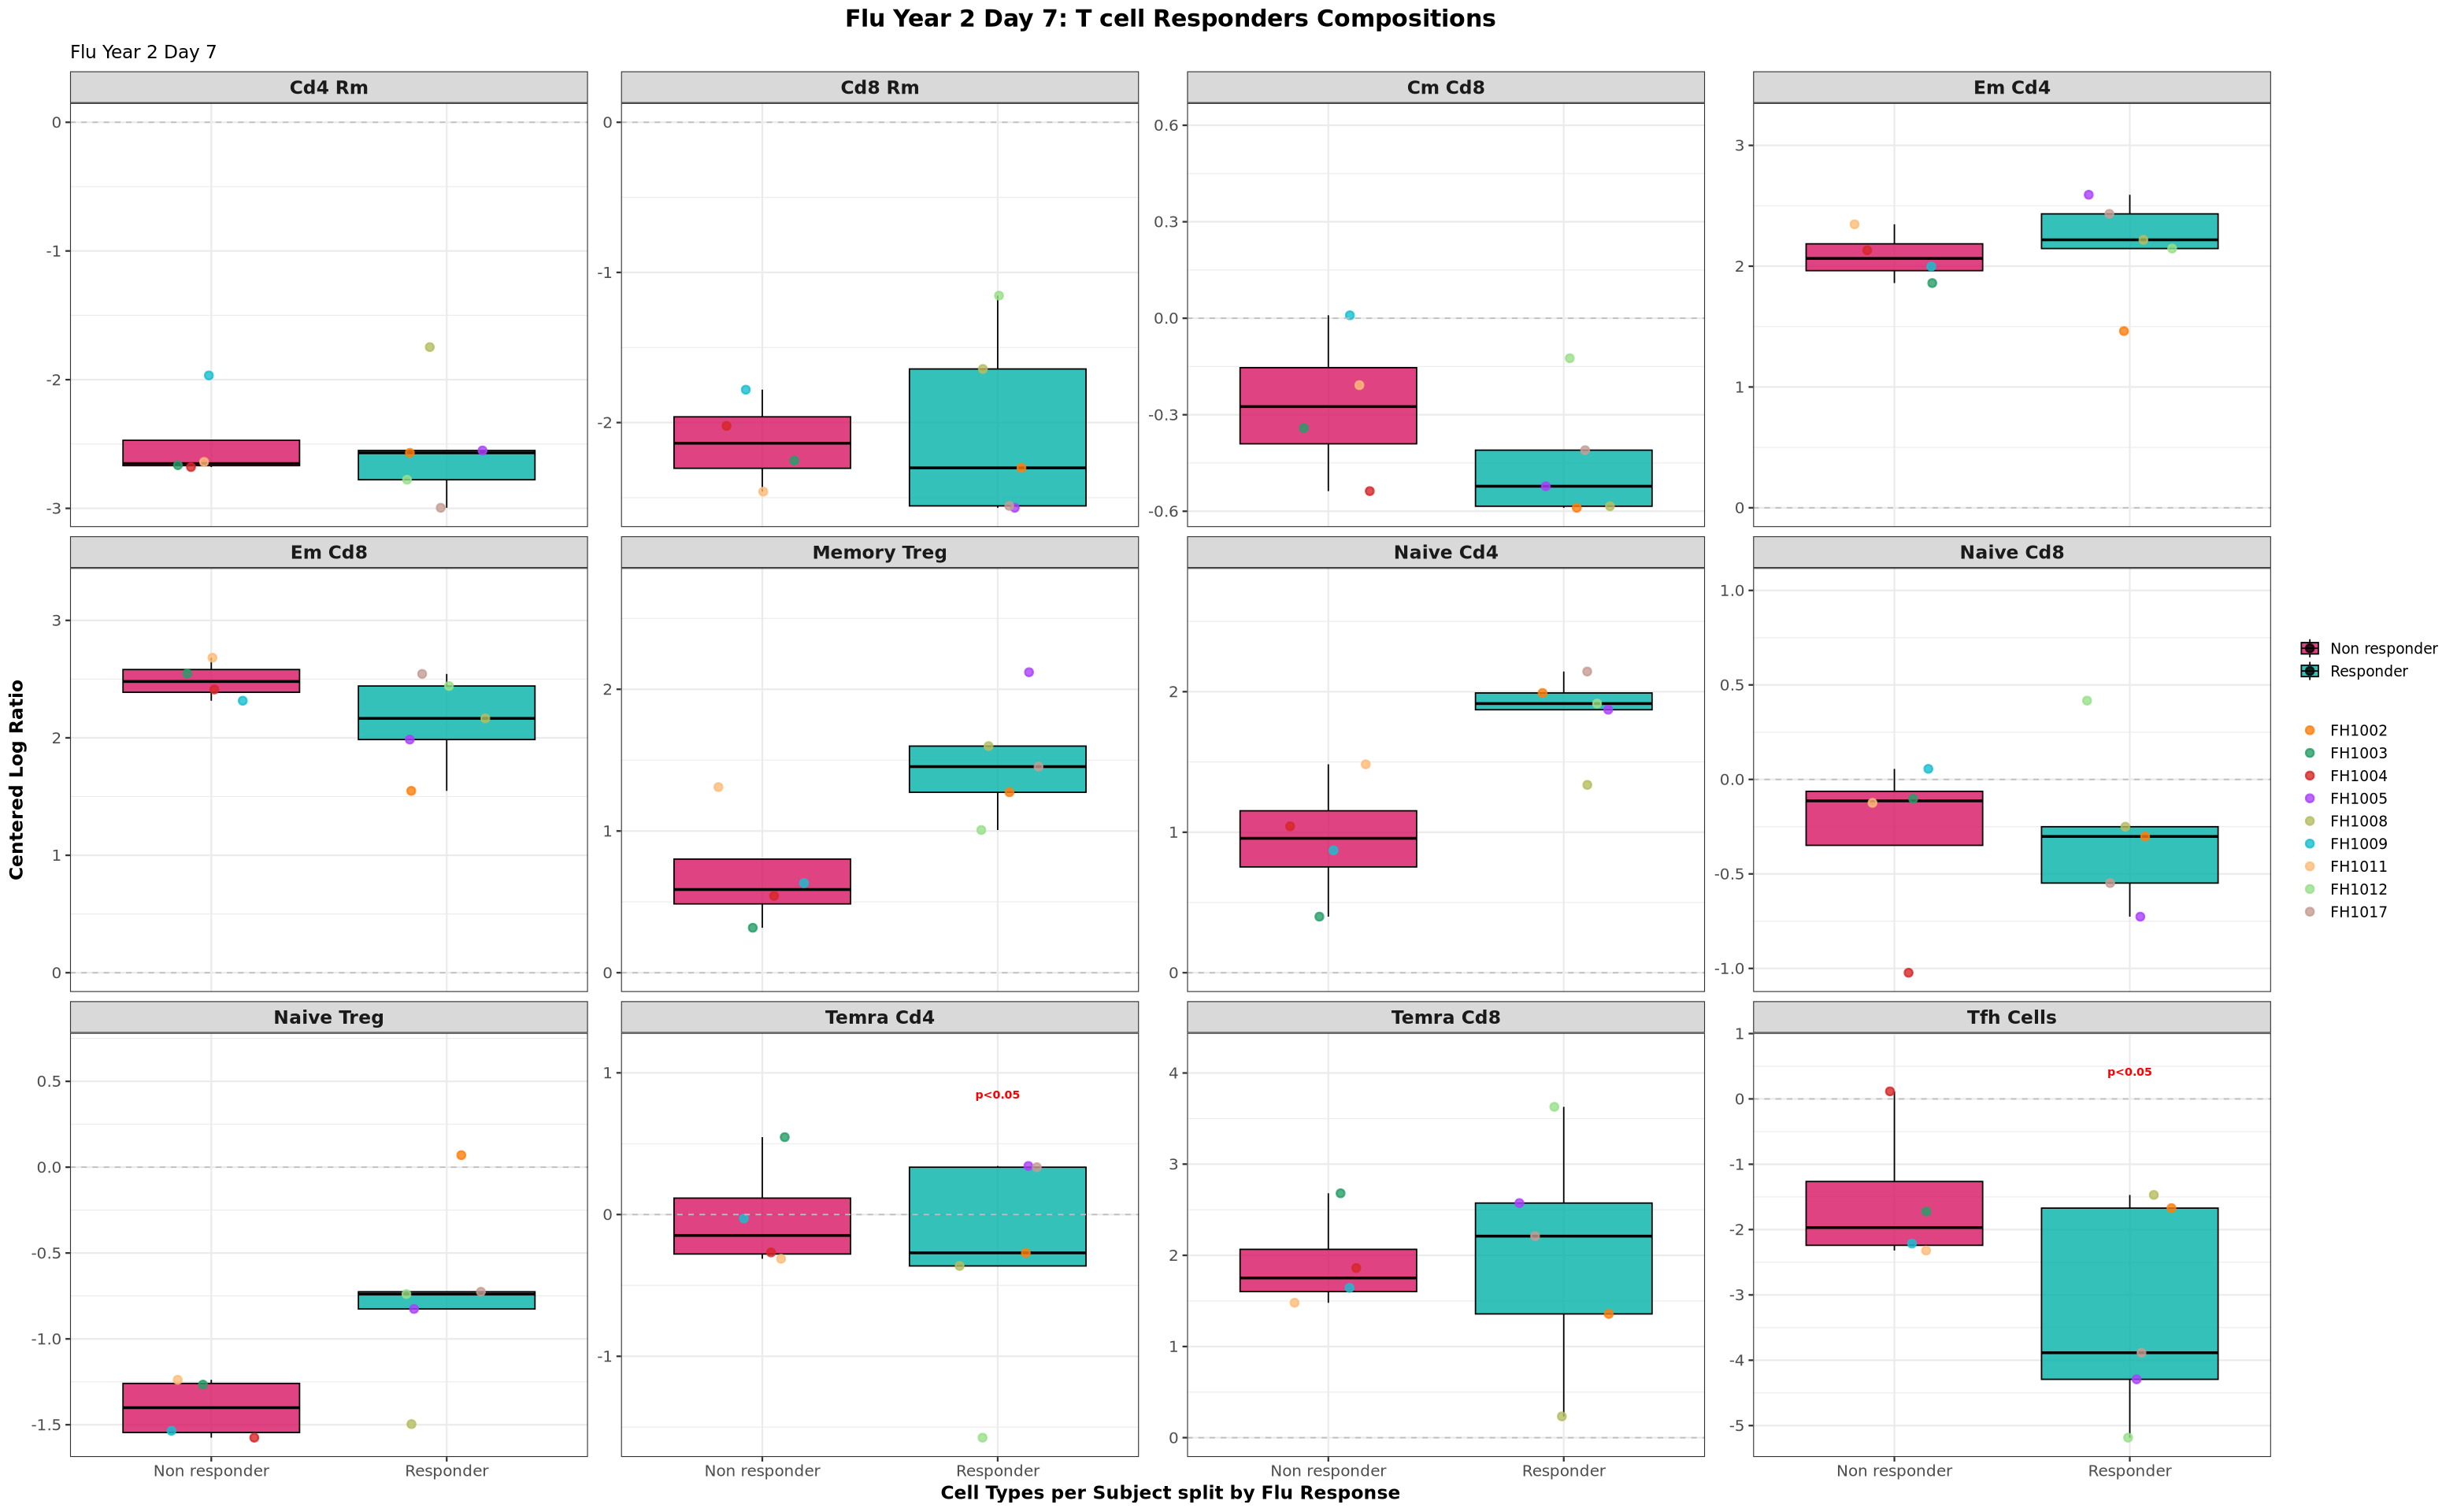

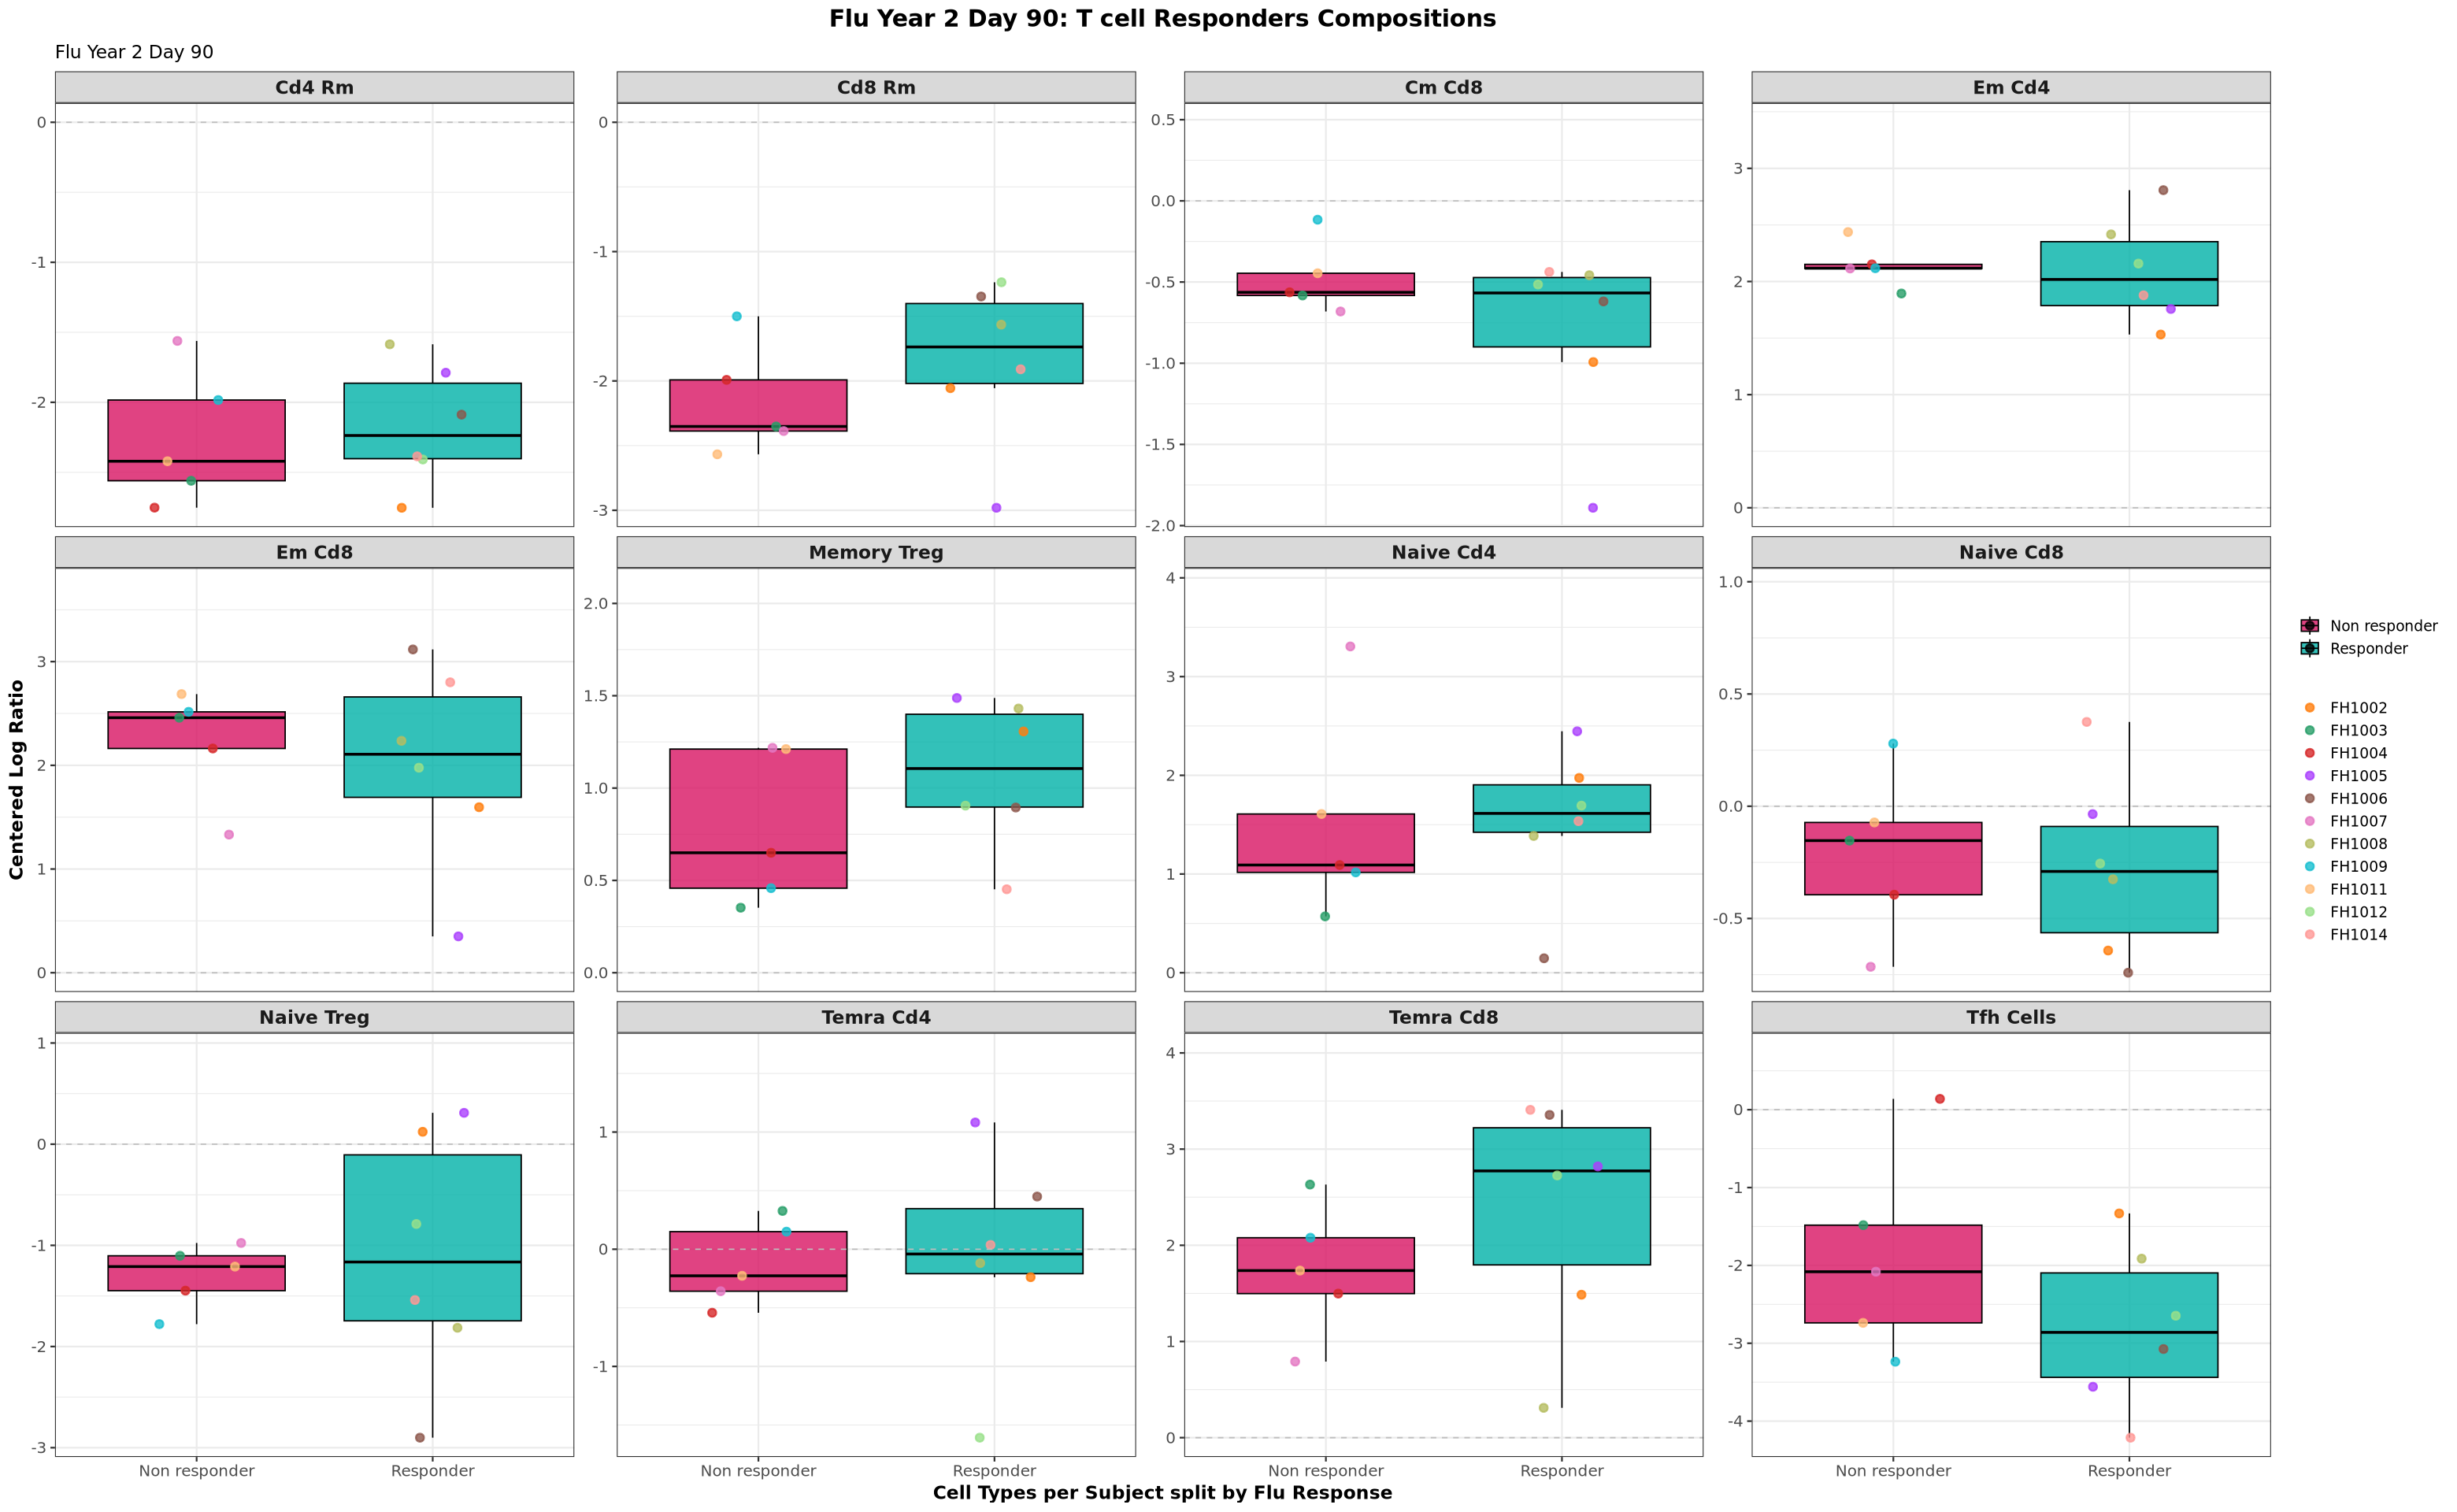

In [4]:
options(repr.plot.width = 26, repr.plot.height = 16)

plot_celltype_clr <- function(
    input_csv,
    treatment_label,
    celltype_level,
    title,
    subtitle,
    file_save_name = "boxplot",
    color_map = c(
      "FH1001" = "#1f77b4", "FH1002" = "#ff7f0e", "FH1003" = "#279e68",
      "FH1004" = "#d62728", "FH1005" = "#aa40fc", "FH1006" = "#8c564b",
      "FH1007" = "#e377c2", "FH1008" = "#b5bd61", "FH1009" = "#17becf",
      "FH1010" = "#aec7e8", "FH1011" = "#ffbb78", "FH1012" = "#98df8a",
      "FH1014" = "#ff9896", "FH1016" = "#c5b0d5", "FH1017" = "#c49c94",
      "FH1018" = "#f7b6d2", "FH1021" = "#dbdb8d"
    )) {
  
  # Read and filter data
  frequency_plots <- fread(input_csv)
  frequency_plots <- frequency_plots[Flu.Visit == treatment_label]
  frequency_plots <- frequency_plots[Response != ""]
  frequency_plots$facet_label <- stringr::str_to_title(gsub("_", " ", frequency_plots[[celltype_level]]))

  # Perform linear regression for each cell type
  cell_types <- unique(frequency_plots[[celltype_level]])
  regression_results <- data.frame()
  
  for (celltype in cell_types) {
    subset_data <- frequency_plots[frequency_plots[[celltype_level]] == celltype, ]
    
    if (nrow(subset_data) > 3) {
      model <- lm(frequency_clr ~ Sex + Response, data = subset_data)
      model_summary <- summary(model)
      
      response_pval <- model_summary$coefficients["ResponseResponder", "Pr(>|t|)"]
      sex_pval <- if("SexM" %in% rownames(model_summary$coefficients)) {
        model_summary$coefficients["SexM", "Pr(>|t|)"]
      } else { NA }
      
      regression_results <- rbind(regression_results, data.frame(
        celltype = celltype,
        facet_label = stringr::str_to_title(gsub("_", " ", celltype)),
        response_pval = response_pval,
        sex_pval = sex_pval,
        response_coeff = model_summary$coefficients["ResponseResponder", "Estimate"],
        adj_r_squared = model_summary$adj.r.squared
      ))
    }
  }
  
  # Format p-values - only show if significant
  regression_results$response_p_text <- ifelse(
    regression_results$response_pval < 0.001, "p<0.001",
    ifelse(regression_results$response_pval < 0.01, "p<0.01",
           ifelse(regression_results$response_pval < 0.05, "p<0.05", ""))
  )

  regression_results$sex_p_text <- ifelse(
    is.na(regression_results$sex_pval), "",
    ifelse(regression_results$sex_pval < 0.001, "Sex: p<0.001",
           ifelse(regression_results$sex_pval < 0.01, "Sex: p<0.01",
                  ifelse(regression_results$sex_pval < 0.05, "Sex: p<0.05", "")))
  )

  # Calculate y positions for annotations
  max_y <- aggregate(frequency_clr ~ facet_label, data = frequency_plots, max)
  regression_results <- merge(regression_results, max_y, by = "facet_label")
  regression_results$y_response <- regression_results$frequency_clr + 0.3
  regression_results$y_sex <- regression_results$frequency_clr + 0.6

  height <- ceiling(length(unique(frequency_plots[[celltype_level]])) / 4) * 7

  # Create plot
  p <- ggplot(frequency_plots, aes(x = Response, y = frequency_clr, fill = Response)) +
    geom_boxplot(alpha = 0.8, outlier.shape = NA, color = "black") +
    geom_jitter(aes(color = Subject), width = 0.2, size = 2.2, stroke = 1, alpha = 0.8) +
    # Add p-value annotations using geom_text
    geom_text(data = regression_results, 
              aes(x = 2, y = y_response, label = response_p_text),
              inherit.aes = FALSE, size = 3, color = "red", fontface = "bold") +
    geom_text(data = regression_results, 
              aes(x = 2, y = y_sex, label = sex_p_text),
              inherit.aes = FALSE, size = 2.5, color = "blue") +
    facet_wrap(vars(facet_label), scales = "free_y", ncol = 4) +
    labs(
      title = title,
      subtitle = subtitle,
      x = "Cell Types per Subject split by Flu Response",
      y = "Centered Log Ratio"
    ) +
    theme_bw(base_size = 14) +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 18, margin = margin(b = 10)),
      axis.title = element_text(size = 14, face = "bold"),
      axis.text = element_text(size = 12),
      legend.position = "right",
      legend.title = element_blank(),
      strip.text = element_text(size = 14, face = "bold")
    ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "gray") +
    scale_fill_manual(values = c("Responder" = "#00b2a8", "Non responder" = "#d81463")) +
    scale_color_manual(values = color_map)

  return(p)
}

timepoint_labels <- c(
    "Flu Year 1 Stand-Alone" = "Y1 SA",
    "Flu Year 1 Day 0" = "Y1 Day 0", 
    "Flu Year 1 Day 7" = "Y1 Day 7",
    "Flu Year 1 Day 90" = "Y1 Day 90",
    "Flu Year 2 Stand-Alone" = "Y2 SA",
    "Flu Year 2 Day 0" = "Y2 Day 0",
    "Flu Year 2 Day 7" = "Y2 Day 7", 
    "Flu Year 2 Day 90" = "Y2 Day 90"
)

all_regression_results <- list()

for (visit in names(timepoint_labels)) {
    
    regression_results <- plot_celltype_clr(
        input_csv = "/home/workspace/pbmc_flow/data/tcell_composition_clr_results.csv",
        treatment_label = visit,
        celltype_level = "population",
        title = paste0(visit, ": T cell Responders Compositions"),
        subtitle = visit
    )
    
    all_regression_results[[visit]] <- regression_results
}

# View regression results
print(all_regression_results)